# Notes

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib as mpl
import matplotlib.patches as mpatches
import cv2
from pylab import cm
from matplotlib.colors import LogNorm
from scipy.spatial import distance
from scipy.optimize import curve_fit
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

# adding the infomap libs
from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
from infomap_utils import make_binTuple_to_clusterIdx_dict
from post_processing import contiguous_regions
from post_processing import process_1D_timeseries

# from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL, compute_pitch_angles
# from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
# from post_processing import contiguous_regions
# from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
# from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions 

In [3]:
def return_state_probabilities_from_state_tseries(state_tseries, numLabelledStates):
    ''' Return the probabilities of each state in the state_tseries. 
        Each value in state_tseries is between 0 and numLabelledStates-1, or NaN,
        or -1 if it was belonging to another cluster (nonlabelled cluster)
        Return the probability of each state as a vector, with the last entry being prob
        of another cluster, and NaN data excluded.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from -1,  
                   Can contains NaNs.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    state_probs: 1D array of shape (numLabelledStates+1,), containing the probability of 
                 each cluster idx and lastly the probability of nonlabelled clusters
    '''
    # add one state for -1 (nonlabelled cluster)
    numStates = numLabelledStates + 1
    # preallocate the output
    state_probs = np.zeros((numStates,))
    #  find the number of frames in total excluding NaN frames
    state_tseries_nanless = state_tseries[~np.isnan(state_tseries)]
    numFrames = state_tseries_nanless.shape[0]
    # if we have no non-nan frames, all probs are zero except the last
    if numFrames == 0:
        return state_probs
    else:
        # first compute main states probs
        for stateIdx in range(numLabelledStates):
            state_counts = np.where(state_tseries_nanless==stateIdx)[0].shape[0]
            state_probs[stateIdx] = state_counts / numFrames
        # now add the final NaN probability
        other_state_counts = np.where(state_tseries_nanless==-1)[0].shape[0]
        state_probs[-1] = other_state_counts / numFrames
        return state_probs


    
def compute_state_probabilities_in_time_windows(state_tseries, time_windows, numLabelledStates):
    ''' Compute the probability of each of the state indices in state_tseries, in
        each of the windows in time_windows.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from 0 to (numLabelledClusters-1)
                   for the labelled states, -1 for all nonlabelled states, and NaN for missing data.
    time_windows: array of shape (numWins,2), where each row contains a start frame
                  and a stop frame which define a region in time. The probabilities
                  are estimated in each of these regions in time.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    window_state_probabilities: a (numWinds, numLabelledStates+1) array containing the 
                                probability of each cluster idx and lastly the probability of 
                                nonlabelled cluster occuring. 
                                
    --- see also ---
    return_state_probabilities_from_state_tseries: 
    the function which does the main computation in each time window.
    
    '''
    numWins = time_windows.shape[0]
    window_state_probabilities = np.zeros((numWins, numLabelledStates+1)) # plus1 for the nonlabelled states
    for winIdx in range(numWins):
        w0,wE = time_windows[winIdx]
        win_data = state_tseries[w0:wE]
        win_state_probs = return_state_probabilities_from_state_tseries(win_data, numLabelledStates)
        window_state_probabilities[winIdx] = win_state_probs
    return window_state_probabilities

In [4]:
def return_region_win_state_probs(region_data, all_exp_window_state_probabilities, all_exp_time_windows, all_exp_numFrames):
    ''' Return the list over fight-bouts, containing the windowed state probabilities for the chosen region.
    
    --- args ---
    region_data: array (numBouts,3), where first col is exp idxs, 2nd and 3rd cols are the start/stop
                 frames of certain regions, e.g. 3 mins before a fightbout.
    
    all_exp_window_state_probabilities: the list over experiments, containing the windowed state probability of
                                        infomap clusters, e.g. each element of the list is a (numWins, 11) array,
                                        where 11 is the number of states and state vals sum to 1.
                                        
    all_exp_time_windows: the list over experiments, with elements being the time windows associated with the 
                          state probabilities in all_exp_window_state_probabilities.
                          
    all_exp_numFrames: a list over experiments containing the number of frames in each experiment.
                          
    --- return ---
    exps_region_win_state_probs: a list over fight bouts, where each element is a (numRegionWins,numStates) array
                                 of state proabilities for windows during the chosen region for a particular fight bout.
                                 
    --- see also ---
    find_time_window_indices_bounding_start_and_stop_frame()
    
    '''
    #exps_region_time_wins = []
    exps_region_win_state_probs = []

    skipped_bIdxs = []
    for bIdx in range(region_data.shape[0]):
        expIdx, t0, tE = region_data[bIdx]
        
        # if t0 is negative, exclude this fight bout
        # if tE is greater than the number of frames in the experiment, exclude fight bout
        if t0 < 0:
            skipped_bIdxs.append(bIdx)
            continue
        expnfs = expNumFrames[expIdx]
        if tE > expnfs:
            skipped_bIdxs.append(bIdx)
            continue

        exp_win_state_probs = all_exp_window_state_probabilities[expIdx]
        exp_time_wins = all_exp_time_windows[expIdx]

        desired_first_win_idx, desired_last_win_idx = find_time_window_indices_bounding_start_and_stop_frame(exp_time_wins, 
                                                                                                             t0, tE)

        #region_time_wins = exp_time_wins[desired_first_win_idx:desired_last_win_idx+1, :] #+1 to get the last win
        region_win_state_probs = np.copy(exp_win_state_probs[desired_first_win_idx:desired_last_win_idx+1, :])

        #exps_region_time_wins.append(region_time_wins)
        exps_region_win_state_probs.append(region_win_state_probs)
    
    
    return exps_region_win_state_probs



def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx



def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)

In [5]:

def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    
    
    # for the end window, we need to do a check to make sure stopFrame is not
    # beyond our windows
    
    # if tE is beyond the end of the last window, use the last window
    if time_windows[:,1][-1] <= stopFrame:
        desired_last_win_idx = time_windows.shape[0] - 1
    # otherwise find the first window beyond tE
    else:
        desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx

# load the tracking data

In [6]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

    


# Load the main infomap data

In [7]:
infomap_data_loadpath

'/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5'

In [8]:

# VIEW THE CONTENTS ##
with h5py.File(infomap_data_loadpath, 'r') as hf:
    for key in hf.keys():
        print(key)

NaN_row_bin_tup_arr
NaN_row_idxs
cluster_state_idxs
cluster_state_tuples
dpp_bins
edited_transition_matrix
numClusters
numInfoTrials
sorted_eig_vals
sorted_eig_vecs
tau
tet_l_bins
tet_w_bins
transMat_row_bin_tup_arr
tseries


In [9]:
## Load the main data saved in the h5 file ##

with h5py.File(infomap_data_loadpath, 'r') as hf:
    tseries = hf['tseries'][:]
    transition_matrix = hf['edited_transition_matrix'][:]
    dpp_bins = hf['dpp_bins'][:]
    tet_w_bins = hf['tet_w_bins'][:]
    tet_l_bins = hf['tet_l_bins'][:]
    numClusters = hf['numClusters'][()]
    # other
    NaN_row_bin_tup_arr = hf['NaN_row_bin_tup_arr'][:]
    NaN_row_idxs = hf['NaN_row_idxs'][:] 
    numInfoTrials = hf['numInfoTrials'][()]
    tau = hf['tau'][()]
    transMat_row_bin_tup_arr  = hf['transMat_row_bin_tup_arr'][:]
    
cluster_state_tuples = []
cluster_state_idxs = []
with h5py.File(infomap_data_loadpath, 'r') as hf:
    for clusterIdx in range(numClusters):
        st_idxs = hf['cluster_state_idxs/cluster{0}'.format(clusterIdx)][:]
        st_tups = hf['cluster_state_tuples/cluster{0}'.format(clusterIdx)][:]
        cluster_state_idxs.append(st_idxs)
        cluster_state_tuples.append(st_tups)
        
num_tetW_bins = tet_w_bins.shape[0]-1
num_tetL_bins = tet_l_bins.shape[0]-1
num_dpp_bins = dpp_bins.shape[0]-1


numStates = num_tetW_bins*num_tetL_bins*num_dpp_bins

binTuple_to_clusterIdx_dict = make_binTuple_to_clusterIdx_dict(cluster_state_tuples)

print(infomap_data_loadpath)
print(numStates)
print(numClusters)

/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5
8000
56


# load the post-processed tseries of infomap cluster idxs

In [187]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath),
                                                                     'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [188]:


# colorlist without red and blue
colorlist = ['#ffe119', '#3cb44b',                    '#f58231', 
             '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
             '#469990', '#dcbeff', '#9A6324', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 


# --- make a cluster_colors list for plotting voxels --- #
alpha_val_1 = 0.8
cluster_colors = [ [0,0,0,0] for i in range(len(state_names)) ]
for clIdx in range(len(state_names)):
    # imported from matplotlib colors to_rgb
    col = to_rgb(colorlist[clIdx])
    cluster_colors[clIdx][0] = col[0]
    cluster_colors[clIdx][1] = col[1]
    cluster_colors[clIdx][2] = col[2]
    cluster_colors[clIdx][3] = alpha_val_1


In [189]:
state_names = ['circling',
             'direct away',
             'winner attack',
             'loser attack',
             'display',
             'direct to',
             'middle circling',
             'loser approach',
             'winner approach',
             'parallel']

state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'loser approach',
 'winner approach',
 'parallel']

In [190]:

# these are the state names of the clusterIdx_edited_postProced_tseries
all_state_names = ['circling',
                 'direct away',
                 'winner attack',
                 'loser attack',
                 'display',
                 'direct to',
                 'middle circling',
                 'L approach',
                 'W approach',
                 'parallel',
                 'non-fight clusters']

state_names = list(all_state_names[:-1])

all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [191]:
len(all_state_names)

11

In [192]:
numLabelledStates = len(state_names)
numLabelledStates


10

In [193]:
totalNumStates = numLabelledStates+1
totalNumStates

11

In [194]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [195]:
# the filepaths for loading how clusterIdxs were merged and reordered
infomap_edited_cluster_info_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                                  'infomap_data/editing_clusterIdx_info.h5')
with h5py.File(infomap_edited_cluster_info_path, 'r') as hf:
    original_cluster_idxs = hf['original_cluster_idxs'][:]
    edited_cluster_idxs = hf['edited_cluster_idxs'][:]


# --- create the edited state tuples --- #

edited_cluster_state_tuples = []

for newClIdx in np.unique(edited_cluster_idxs):
    
    # find the original clusterIdxs for this new clusterIdx
    cl_new_indices = np.where(edited_cluster_idxs==newClIdx)[0]
    
    # get the corresponding original idxs
    cl_original_clIdxs = [original_cluster_idxs[i] for i in cl_new_indices]
    
    # combine the voxels for the original clusterIdx that go into this new clusterIdx
    cl_original_voxels = np.concatenate([cluster_state_tuples[oldClIdx] for oldClIdx in cl_original_clIdxs])
    edited_cluster_state_tuples.append(cl_original_voxels)

# Compute kin vars for all experiments

In [19]:
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from kinematics import compute_pec_pec_distance_dot, compute_coordinate_origin_z_dot

In [20]:
interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording

In [21]:
t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

exp_phi_dots = []
exp_dpp_dots = []
exp_pec_z_differences = []
exp_Oz_dots = []


for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    raw_traj = raw_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
    
    phi_dot = compute_phi_dot_from_raw_trajectories(raw_traj, winIdx, losIdx, dt=dt,
                                                    interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                                    smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_phi_dots.append(phi_dot)
    
    
    signed_pec_z_difference = compute_signed_pec_z_difference(smooth_traj, winIdx, losIdx)
    exp_pec_z_differences.append(signed_pec_z_difference)
    
    dpp_dot = compute_pec_pec_distance_dot(raw_traj,  dt=dt,
                                            interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                            smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_dpp_dots.append(dpp_dot)
    
    
    Oz_dot = compute_coordinate_origin_z_dot(raw_traj, winIdx, losIdx, dt=dt,
                                             interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd, 
                                             smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_Oz_dots.append(Oz_dot)
    
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200129_140656


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_153857


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_181614


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200207_161445


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200213_154940


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200214_153519


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200217_160052


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200218_153008


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200316_163320


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200327_154737


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200330_161100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200331_162136


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200520_152810


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200521_154541


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200525_161602


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]
/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200828_155504


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200902_160124


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200903_160946


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]



finished: 19.502563497051597 s


In [32]:
# --- Master sets of plotting --- #
dpp_dot_master = np.concatenate(exp_dpp_dots)
phi_dot_master = np.concatenate(exp_phi_dots)
pec_z_difference_master = np.concatenate(exp_pec_z_differences)
Oz_dots_master = np.concatenate(exp_Oz_dots)

dpp_master = np.concatenate(exp_dpps)
tetW_master = np.concatenate(exp_tetWs)
tetL_master = np.concatenate(exp_tetLs)




# Condition state vars on cluster membership

In [33]:
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [34]:
np.unique(clusterIdx_edited_postProced_tseries_master)

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [35]:
phi_dot_master.shape

(16044324,)

In [36]:
all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [37]:
# ---- get the distributions for each cluster ---- #

cluster_dppdots_master = []
cluster_phidots_master = []


for clusterIdx in range(numClusters):
    
    cluster_idx_frames_master = np.where(clusterIdx_edited_postProced_tseries_master==clusterIdx)[0]
    
    cls_dppdots = dpp_dot_master[cluster_idx_frames_master]
    cls_phidots = phi_dot_master[cluster_idx_frames_master]


    cluster_dppdots_master.append(cls_dppdots)
    cluster_phidots_master.append(cls_phidots)

# load the raw clusterIdx timeseries for all experiments

In [196]:
# If the below doesn't work, make sure the 'compute' section above has been run at least once

In [197]:
infomap_data_loadpath

'/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5'

In [198]:
# load
all_exps_clusterIdx_tseries = []
all_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath), 'exp_clusterIdx_timeseries.h5')
with h5py.File(all_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        exp_cls_tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_clusterIdx_tseries.append(exp_cls_tseries)
        
# make the master-set
clusterIdx_tseries_master = np.concatenate(all_exps_clusterIdx_tseries)

In [199]:
clusterIdx_tseries_master

array([36., 36., 36., ..., 11., 11., 11.])

In [200]:
np.unique(clusterIdx_tseries_master)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., nan])

## post-process the N=56 cluster ts data

In [201]:
clusterIdx_tseries_master.shape

(16044324,)

In [202]:
# --- params --- #
MINSIZE = 5  # remove any contiguous regions smaller than MINSIZE
MAXGAP= 5   # join together contiguous regions of same clusterIdx separated by less than MAXGAP frames

# first remove small regions
# then join regions 


# --- Make a list of post-processed edited clusterIdx tseries --- #
# this will be updated in the coming sections
all_exps_postProced_original_clusterIdx_tseries = []
for expIdx in range(len(expNames)):
    cls_ts = np.copy(all_exps_clusterIdx_tseries[expIdx])
    all_exps_postProced_original_clusterIdx_tseries.append(cls_ts)
    
    
# --- Merge contiguous regions with smaller separations --- #
# MAXGAP
for expIdx in range(len(expNames)):
    # dont make a copy, because we want to edit the entries of all_exps_edited_postProced_clusterIdx_tseries
    exp_edited_postProced_cls_ts = all_exps_postProced_original_clusterIdx_tseries[expIdx]
    
    # loop over clusters, ignoring -1
    for clusterIdx in range(numClusters):
        # create a binary array, and the inverse binary array
        # (where clusterIdx is, and where clusterIdx isn't )
        exp_clIdx_bin_arr_original = exp_edited_postProced_cls_ts == clusterIdx
        exp_clIdx_bin_arr_inverse = ~exp_clIdx_bin_arr_original
        
        # get the regions, and lengths, of the inverse,
        # where these regions are now contiguous gaps between clusterIdx contiguous regions
        inverse_region_data = contiguous_regions(exp_clIdx_bin_arr_inverse)
        inverse_region_lengths = np.diff(inverse_region_data, axis=1)[:,0]
        
        #---- Apply MAXGAP --- #
        # join contiguous regions which are separated by less than MAXGAP
        for regionIdx in range(inverse_region_lengths.shape[0]):
            if inverse_region_lengths[regionIdx] <= MAXGAP:
                f0, fE = inverse_region_data[regionIdx]
                exp_edited_postProced_cls_ts[f0:fE] = clusterIdx
                
                
original_clusterIdx_postProced_tseries_master = np.concatenate( all_exps_postProced_original_clusterIdx_tseries )
original_clusterIdx_postProced_tseries_master.shape

(16044324,)

In [203]:
len(all_exps_postProced_original_clusterIdx_tseries)

22

# Get the longest regions for an original cluster index

In [ ]:
# We provide a master timeseries, and it returns regions in the units of the master timeseries,
# so we can find the associated data in other master timeseries

In [204]:


desired_cluster_idxs = list(range(numClusters))

input_clusterIdx_tseries = np.copy(original_clusterIdx_postProced_tseries_master)


# ------  get the regions ------------------#

cluster_regions = []
cluster_regions_sizes = []

for clIdx in desired_cluster_idxs: 

    # get a bool array representing true for this clusterIdx
    clIdx_boolarr = input_clusterIdx_tseries == clIdx
    # get the contiguous regions of this bool array
    cl_regions = contiguous_regions(clIdx_boolarr)
    # get the size of the regions
    cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)
    # record
    cluster_regions.append(cl_regions)
    cluster_regions_sizes.append(cl_region_sizes)
    
# ----- now sort the regions by length ----- #

cluster_sorted_regions = []
cluster_sorted_region_sizes = []

for ii in range(len(desired_cluster_idxs)):

    regions = cluster_regions[ii]
    region_sizes = cluster_regions_sizes[ii]

    sorted_regions = np.zeros_like(regions)
    sorted_region_sizes = np.zeros_like(region_sizes)

    sorted_reg_idxs = np.argsort(region_sizes)[::-1]
    for regIdx in range(sorted_reg_idxs.shape[0]):
        sorted_regions[regIdx] = regions[sorted_reg_idxs[regIdx]]
        sorted_region_sizes[regIdx] = region_sizes[sorted_reg_idxs[regIdx]]
        
    cluster_sorted_regions.append(sorted_regions)
    cluster_sorted_region_sizes.append(sorted_region_sizes)
    
    
# ---------- finally, output variables ----#
    
original_clusterIdx_reg_sizes = list(cluster_sorted_region_sizes)
original_clusterIdx_reg_framesRanges = list(cluster_sorted_regions)

# Get the longest regions for an edited cluster index


In [28]:
# We provide a master timeseries, and it returns regions in the units of the master timeseries,
# so we can find the associated data in other master timeseries

In [205]:
desired_cluster_idxs = list(range(numLabelledStates))

input_clusterIdx_tseries = np.copy(clusterIdx_edited_postProced_tseries_master)


# ------  get the regions ------------------#

cluster_regions = []
cluster_regions_sizes = []

for clIdx in desired_cluster_idxs: 

    # get a bool array representing true for this clusterIdx
    clIdx_boolarr = input_clusterIdx_tseries == clIdx
    # get the contiguous regions of this bool array
    cl_regions = contiguous_regions(clIdx_boolarr)
    # get the size of the regions
    cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)
    # record
    cluster_regions.append(cl_regions)
    cluster_regions_sizes.append(cl_region_sizes)
    
# ----- now sort the regions by length ----- #

cluster_sorted_regions = []
cluster_sorted_region_sizes = []

for ii in range(len(desired_cluster_idxs)):

    regions = cluster_regions[ii]
    region_sizes = cluster_regions_sizes[ii]

    sorted_regions = np.zeros_like(regions)
    sorted_region_sizes = np.zeros_like(region_sizes)

    sorted_reg_idxs = np.argsort(region_sizes)[::-1]
    for regIdx in range(sorted_reg_idxs.shape[0]):
        sorted_regions[regIdx] = regions[sorted_reg_idxs[regIdx]]
        sorted_region_sizes[regIdx] = region_sizes[sorted_reg_idxs[regIdx]]
        
    cluster_sorted_regions.append(sorted_regions)
    cluster_sorted_region_sizes.append(sorted_region_sizes)
    
    
# ---------- finally, output variables ----#
    
edited_clusterIdx_reg_sizes = list(cluster_sorted_region_sizes)
edited_clusterIdx_reg_framesRanges = list(cluster_sorted_regions)

# Create a very well interpolated 3D trajectory master timeseries for visualizations

In [206]:
# post-process the trajectory
interp_max_gap_VIS = 50
interp_polyOrd_VIS = 1

smooth_polyOrd_VIS = 2
smooth_winSize_VIS = 9

In [207]:
numFish=2
numBodyPoints=3

In [54]:
t0 = time.perf_counter()

visualization_trajectories = []

for expIdx, expName in enumerate(expNames):
    print(expIdx)
    
    raw_trajectory = raw_trajectories[expIdx]
    winIdx = winner_idxs[expIdx]
    losIdx = loser_idxs[expIdx]
    
    # put the winner first
    if winIdx == 1:
        raw_trajectory = raw_trajectory[:, ::-1, :, :]
    
    visualization_trajectory = np.ones_like(raw_trajectory)*np.NaN
    for fishIdx in range(numFish):
        for bpIdx in range(numBodyPoints):
            for dimIdx in range(3):
                visualization_trajectory[:,fishIdx,bpIdx,dimIdx] = process_1D_timeseries(raw_trajectory[:,fishIdx,bpIdx,dimIdx],
                                                                                         interp_max_gap=interp_max_gap_VIS,
                                                                                         interp_polyOrd=interp_polyOrd_VIS,
                                                                                         smooth_polyOrd=smooth_polyOrd_VIS,
                                                                                         smooth_winSize=smooth_winSize_VIS)
                
    visualization_trajectories.append(visualization_trajectory)
    
    
tE = time.perf_counter()
print(tE-t0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
34.52611136296764


In [55]:
visualization_trajectories_master = np.concatenate(visualization_trajectories, axis=0)
visualization_trajectories_master.shape

(16044324, 2, 3, 3)

# ------------------------------------

# Fig 5 Panel A - left

In [ ]:
imsavepath = os.path.join('/home/liam/temp/image_transfer/3D_transmat.pdf')


def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# build up the numpy logo
n_voxels = np.zeros((4, 3, 4), dtype=bool)
#n_voxels[0, 0, :] = True
#n_voxels[-1, 0, :] = True
n_voxels[1, 0, 3] = True
n_voxels[3, 0, 1] = True
facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
filled = np.ones(n_voxels.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95



fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)



ax.set_zticklabels([])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)

fig.savefig(imsavepath, transparent=True, dpi=300)

# Fig 5 Panel A - mid

In [ ]:
len(cluster_state_idxs)

In [ ]:
cluster_state_idxs[0]

In [ ]:



def swap_states_i_and_j_in_matrix(Tmat, i, j):
    ''' Return a reordering of the transition matrix, where states i and j
        have been swapped in the ordering of the states.
        
    --- example ---
    # Note: Here we use characters instead of numbers for ease of seeing
    #       the reordering which happens. In practice, the tmat
    #       should be a stochastic matrix.
    
    test_tmat = np.array([['a', 'b', 'c', 'd'],
                          ['e', 'f', 'g', 'h'],
                          ['i', 'j', 'k', 'l'],
                          ['m', 'n', 'o', 'p']])
    i = 1
    j = 2
    test_tmat_permuted = swap_states_i_and_j_in_matrix(test_tmat, i, j)
    test_tmat_permuted
    >> array([['a', 'c', 'b', 'd'],
              ['i', 'k', 'j', 'l'],
              ['e', 'g', 'f', 'h'],
              ['m', 'o', 'n', 'p']]
    '''
    # test that i and j are ok
    numRows, numCols = Tmat.shape
    if numRows != numCols:
        raise TypeError('Tmat is not square')
    numStates = numRows
    if i >= numStates:
        raise TypeError('i index > numStates in Tmat')
    if j >= numStates:
        raise TypeError('j index > numStates in Tmat')
        
    # record the original ith and jth rows and columns
    row_i = np.copy(Tmat[i,:])
    row_j = np.copy(Tmat[j,:])  
    col_i = np.copy(Tmat[:,i])
    col_j = np.copy(Tmat[:,j])
    
    # swap the rows and swap the columns
    Tmat[i,:] = row_j
    Tmat[j,:] = row_i
    Tmat[:,i] = col_j
    Tmat[:,j] = col_i
    
    # now record the elements which need an additional swap
    ii = np.copy(Tmat[i,i])
    ij = np.copy(Tmat[i,j])
    ji = np.copy(Tmat[j,i])
    jj = np.copy(Tmat[j,j])
    
    # now perform the additional swap
    Tmat[i,i] = ji
    Tmat[i,j] = jj
    Tmat[j,i] = ii
    Tmat[j,j] = ij
    
    # finish up    
    return Tmat


def reorder_states_in_transition_matrix(tmat, new_order):
    ''' Return a reorder version of the tmat, where states are permuted into
        the order defined by new_order.
        
    --- args -- 
    tmat: shape=(N,N)
    new_order: shape=(N,)
    
    --- returns ---
    updating_tmat: shape(N,N)
    
    --- see also ---
    swap_states_i_and_j_in_matrix()
    
    --- example ---
    # Note: Here we use characters instead of numbers for ease of seeing
    #       the reordering which happens. In practice, the tmat
    #       should be a stochastic matrix.
    
    tmat = np.array([['a', 'b', 'c', 'd'],
                     ['e', 'f', 'g', 'h'],
                     ['i', 'j', 'k', 'l'],
                     ['m', 'n', 'o', 'p']])
                     
    new_order = np.array([2,3,1,0])
    
    reordered_tmat = reorder_states_in_transition_matrix(tmat, new_order)
    reordered_tmat
    >> array([['k', 'l', 'j', 'i'],
              ['o', 'p', 'n', 'm'],
              ['g', 'h', 'f', 'e'],
              ['c', 'd', 'b', 'a']],
    '''
    # test the tmat for correct format
    numRows, numCols = tmat.shape
    if numRows != numCols:
        raise TypeError('tmat is not square')
    numStates = numRows
    
    # test that the new_order is the correct length
    if new_order.shape[0] != numStates:
        raise TypeError('length of new_order does not match shape of tmat')
 
    # define the current ordering of states, which will be updated
    current_order = np.array([i for i in range(numStates)])
    
    # define the tmat which will be updated
    updating_tmat = np.copy(tmat)
    
    # place states in the new order, state by state
    for updateRowIdx in range(len(new_order)):
    
        #print(current_order)

        # get the i and j for swapping
        i = updateRowIdx
        desired_idx = new_order[updateRowIdx]
        j = int(np.where(current_order==desired_idx)[0])

        # do the swapping
        updating_tmat = swap_states_i_and_j_in_matrix(updating_tmat, i, j)

        # update the current order
        temp_current_order = np.copy(current_order)
        current_order[i] = desired_idx
        current_order[j] = temp_current_order[i]
        
    # finish up
    return updating_tmat

In [ ]:
len(cluster_state_idxs)

In [ ]:
# get the new ordering
new_order = np.concatenate(cluster_state_idxs)

# reorder the matrix
reordered_tmat = reorder_states_in_transition_matrix(transition_matrix, new_order)

In [ ]:
# ----  get the clusterIdxs of the reordered matrix ---- #

reordered_tmat_clusterIdxs = []

for i, clIdxs in enumerate(cluster_state_idxs):
    cl_numstates = clIdxs.shape[0]
    reordered_tmat_clusterIdxs.append(np.array([i for _ in range(cl_numstates)]))
    #print(i, cl_numstates)
    
reordered_tmat_clusterIdxs = np.concatenate(reordered_tmat_clusterIdxs)
reordered_tmat_clusterIdxs

In [ ]:
reordered_tmat_clusterIdxs.shape

In [ ]:
# ---- select only fighting elements of the reordered transition matrix ---- #

fight_cluster_idxs = original_cluster_idxs

fight_rows = []
for idx in range(numStates):
    stIdx = reordered_tmat_clusterIdxs[idx]
    if stIdx in fight_cluster_idxs:
        fight_rows.append(idx)
fight_rows = np.array(fight_rows)

fight_rows.shape

In [ ]:
reordered_tmat_fight = np.copy(reordered_tmat[fight_rows, :])
reordered_tmat_fight = reordered_tmat_fight[:, fight_rows]
reordered_tmat_fight.shape

In [ ]:


fig, axs = plt.subplots()
ax = axs

reordered_tmat_fight_resized = cv2.resize(reordered_tmat_fight, (300,300), interpolation=cv2.INTER_AREA)

im = ax.matshow(reordered_tmat_fight_resized , cmap=cm.Blues, norm=LogNorm(vmin=0.0005, vmax=0.1)) #cm.gray_r

t = [0, 0.01, 0.1, 0.5, 1]
fig.colorbar(im, ticks=t, format="$%.2f$")
fig.tight_layout()

In [ ]:


fig, axs = plt.subplots()
ax = axs

reordered_tmat_fight_resized = cv2.resize(reordered_tmat_fight, (300,300), interpolation=cv2.INTER_AREA)

im = ax.matshow(reordered_tmat_fight_resized , cmap=cm.Blues, norm=LogNorm(vmin=0.0005, vmax=0.5))

t = []
fig.colorbar(im, ticks=t, format="$%.2f$")
fig.tight_layout()

#fig.savefig('/home/liam/temp/image_transfer/fig5_a_inset_colorbarIM.png', dpi=300, transparent=False)

In [ ]:
fig, axs = plt.subplots(figsize=(2.5,2.5))
ax = axs

reordered_tmat_fight_resized = cv2.resize(reordered_tmat_fight, (300,300), interpolation=cv2.INTER_AREA)

im = ax.matshow(reordered_tmat_fight_resized , cmap=cm.Blues, norm=LogNorm(vmin=0.0005, vmax=0.1))

ax.set_yticks([0, reordered_tmat_fight_resized.shape[0]])
ax.set_xticks([0, reordered_tmat_fight_resized.shape[0]])

ax.set_yticklabels([])
ax.set_xticklabels([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)


fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/fig5_a_inset.png', dpi=300, transparent=False)

# Fig 5 Panel A - right

In [ ]:
edited_cluster_state_tuples[0]

/tmp/ipykernel_1811553/4033330517.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
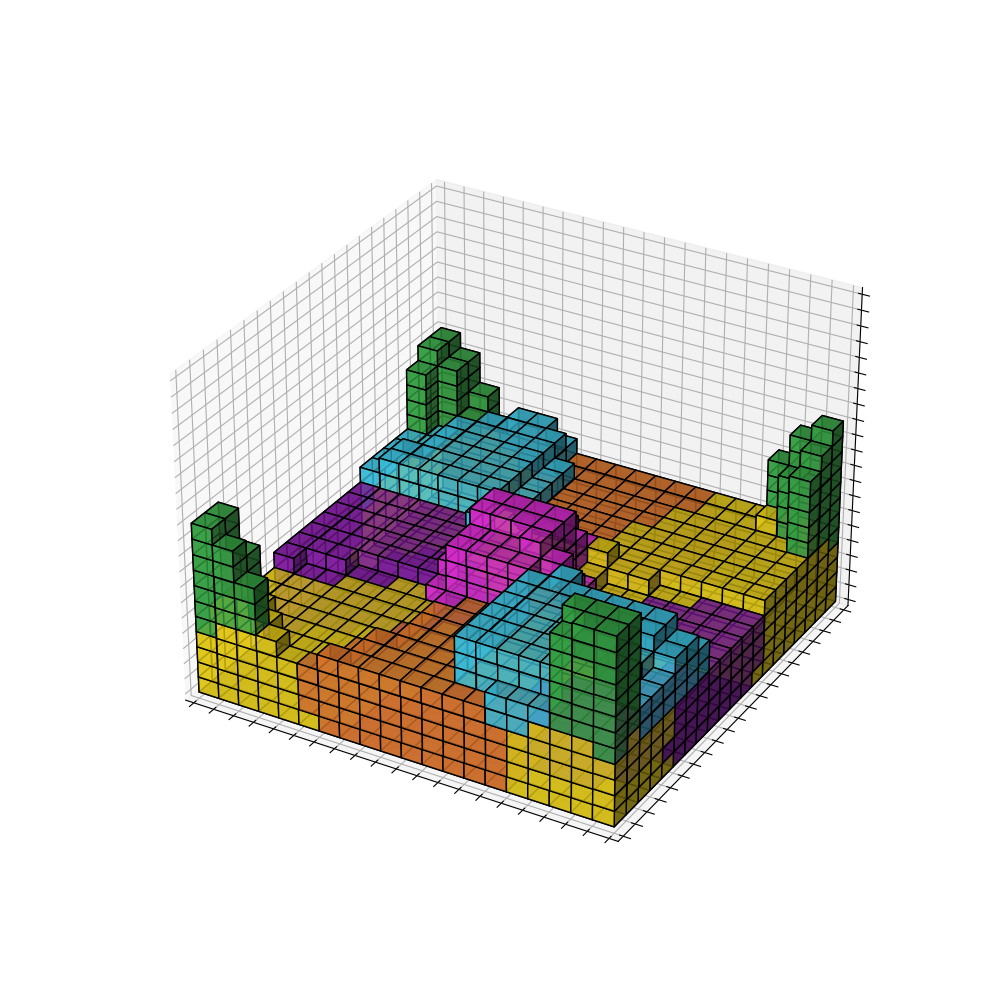

In [212]:
# prepare some info
imsavepath = os.path.join('/home/liam/temp/image_transfer/voxel_plot_new.png')

# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))

# --- Make the main voxel array --- #
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)

# --- set the colors of the background voxels --- #
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)

# # --- draw as many clusters as we want --- #

for i in range(6):
    cluster_voxels = edited_cluster_state_tuples[i]
    cluster_col = cluster_colors[i]
    num_cls_voxs = cluster_voxels.shape[0]
    for voxIdx in range(num_cls_voxs):
        vox = cluster_voxels[voxIdx]
        colors[vox[0], vox[1], vox[2]] = cluster_col
        voxelarray[vox[0], vox[1], vox[2]] = True

# ----- plot everything ----------#
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.voxels(voxelarray, facecolors=colors, edgecolor='k');

ax.set_xlabel('', fontsize=24)
ax.set_ylabel('', fontsize=24)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('', fontsize=24, rotation=90)

ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)

ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([], fontsize=16);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([], fontsize=16);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([], fontsize=16);

# increase the spacing between axes labels and figure
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

 # save the image
dpi = 300
fig.tight_layout()
fig.savefig(imsavepath, dpi=dpi, transparent=True, pad_inches=0)

# Fig 5 Panel B - left and middle

In [219]:
# I want to use my consistent colorings for state indices.
# See figure 6, and the voxel plot in A.
# So this is copied from the section below on the 3D voxel plot
# i.e. the color for loser attacks
loser_attack_color = [0.5686274509803921, 0.11764705882352941, 0.7058823529411765, 0.2]




# We want to work with original clusterIdx for loser left attack
clusterIdx=3

In [90]:
# now I need to convert this data to points in voxel space, but not in a binary way, keeping full resolution

def convert_state_data_to_voxel_positions(state_data, 
                                          dpp_binStart=0, dpp_binStop=20, dpp_numbins=20,
                                          tetW_binStart=-np.pi, tetW_binStop=np.pi, tetW_numbins=20, 
                                          tetL_binStart=-np.pi, tetL_binStop=np.pi, tetL_numbins=20):
    ''' Turn a timeseries of (dpp,tetW,tetL) into a timeseries of locations in the matplotlib voxel state space.
    '''
    dpp_data = state_data[:,0]
    tetW_data = state_data[:,1]
    tetL_data = state_data[:,2]
    
    dpp_bin_total_range = np.abs(dpp_binStop - dpp_binStart)
    tetW_bin_total_range = np.abs(tetW_binStop - tetW_binStart)
    tetL_bin_total_range = np.abs(tetL_binStop - tetL_binStart)
    
    dpp_voxel_points = (( np.abs(dpp_data-dpp_binStart) ) / dpp_bin_total_range) * dpp_numbins
    tetW_voxel_points = (( np.abs(tetW_data-tetW_binStart) ) / tetW_bin_total_range) * tetW_numbins
    tetL_voxel_points = (( np.abs(tetL_data-tetL_binStart) ) / tetL_bin_total_range) * tetL_numbins
    
    return np.stack([dpp_voxel_points, tetW_voxel_points, tetL_voxel_points], axis=1)



def return_plotting_lims_for_3D_trajectory(trajectory_data, padding_depth=[1.5, 1.5, 1.5]):
    ''' Given a trajectory of the shape (nfs,numFish,numBodyPoints,3), return a dictionary
        containing useful plot limits for plotting this trajectory.
    '''
    plot_params_dict = {}

    x_min = np.nanmin(plot_data[:,:,:,0], axis=(0,1,2))
    x_max = np.nanmax(plot_data[:,:,:,0], axis=(0,1,2))

    y_min = np.nanmin(plot_data[:,:,:,1], axis=(0,1,2))
    y_max = np.nanmax(plot_data[:,:,:,1], axis=(0,1,2))

    z_min = np.nanmin(plot_data[:,:,:,2], axis=(0,1,2))
    z_max = np.nanmax(plot_data[:,:,:,2], axis=(0,1,2))

    plot_x_min = x_min - padding_depth[0]
    plot_x_max = x_max + padding_depth[0]

    plot_y_min = y_min - padding_depth[1]
    plot_y_max = y_max + padding_depth[1]

    plot_z_min = z_min - padding_depth[2]
    plot_z_max = z_max + padding_depth[2]

    plot_params_dict.update({'x_min':plot_x_min})
    plot_params_dict.update({'x_max':plot_x_max})

    plot_params_dict.update({'y_min':plot_y_min})
    plot_params_dict.update({'y_max':plot_y_max})

    plot_params_dict.update({'z_min':plot_z_min})
    plot_params_dict.update({'z_max':plot_z_max})
    return plot_params_dict

## plot a bunch of examples

In [61]:
# Using the below cell, I identified the following examples that might work

activation_idx_choices_for_loser_attacks = [104, 106, 111, 120, 122, 126, 181, 187, 191, 192]

In [60]:

# for cluster_activation_idx in range(100,200):

# #cluster_activation_idx = 35

#     # ------------------------------------------#

#     # parse the region data
#     reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
#     reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

#     # get the visualization 3D trajectory
#     reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

#     # get the state-space data
#     dpp = dpp_master[reg_f0:reg_fE]
#     theta_w = tetW_master[reg_f0:reg_fE]
#     theta_l = tetL_master[reg_f0:reg_fE]
#     region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

#     # get the voxel data for drawing the trajectory
#     region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
#                                                               dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
#                                                               tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
#                                                               tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)
    
#     fig = plt.figure(figsize=(5,5))
    
#     ax = fig.add_subplot(1,1,1, projection='3d')
#     ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')

#     elev = 30
#     azim = -60
#     ax.view_init(elev, azim)
#     cluster_index_list = list(range(numClusters))
#     other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
#     # prepare some coordinates, based on the number of bins
#     x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#     #  Make the main voxel array 
#     voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
#     # set the colors of the background voxels 
#     colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
#     # the chosen cluster
#     cluster_voxels = cluster_state_tuples[clusterIdx]
#     cluster_col = loser_attack_color
#     num_cls_voxs = cluster_voxels.shape[0]
#     for voxIdx in range(num_cls_voxs):
#         vox = cluster_voxels[voxIdx]
#         colors[vox[0], vox[1], vox[2]] = cluster_col
#         voxelarray[vox[0], vox[1], vox[2]] = True
#     # now start the figure
#     ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#     #ax.set_xlabel(r'$\theta_{W}$')
#     #ax.set_ylabel(r'$\theta_{L}$')
#     #ax.set_zlabel(r'D$_{PP}$')
#     ax.set_xlim(0, num_tetW_bins)
#     ax.set_ylim(0, num_tetL_bins)
#     ax.set_zlim(0, num_dpp_bins)
#     ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
#     ax.set_xticklabels([]);
#     ax.set_xticks(np.arange(num_tetW_bins+1));
#     ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
#     ax.set_yticklabels([]);
#     ax.set_yticks(np.arange(num_tetL_bins+1));
#     ax.set_zticks(np.arange(num_dpp_bins+1));
#     ax.set_zticklabels([]);
#     #  Plot the projections of the cluster onto the walls 
#     min_x = np.min(cluster_voxels[:,0])
#     max_x = np.max(cluster_voxels[:,0])
#     min_y = np.min(cluster_voxels[:,1])
#     max_y = np.max(cluster_voxels[:,1])
#     min_z = np.min(cluster_voxels[:,2])
#     max_z = np.max(cluster_voxels[:,2])
#     # find the box for the XY plane
#     xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
#     xy_zs = [0, 0, 0, 0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
#     # find the box for the XZ plane
#     xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
#     xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
#     # find the box for the YZ plane
#     yz_xs = [0, 0, 0, 0, 0]
#     yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
#     yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

#     # ------------------------------------------------------------------#

#     ax.set_zlim(0, 6)

#     # plot the theta loser =0 line on bottom
#     xy_xs = [0, num_tetW_bins]
#     xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
#     xy_zs = [0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


#     # plot the theta winner = 0 extent line
#     xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
#     xy_ys = [0, num_tetW_bins]
#     xy_zs = [0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


#     # ----- plot the trajectory ---- #

#     xs =  region_voxel_data[:,1] #tetw
#     ys =  region_voxel_data[:,2] #tetl
#     zs =  region_voxel_data[:,0] #dpp
#     ax.plot(xs, ys, zs, color='black')


#     # ----- plot the start and end ---- #
#     xs =  region_voxel_data[0:2,1] #tetw
#     ys =  region_voxel_data[0:2,2] #tetl
#     zs =  region_voxel_data[0:2,0] #dpp
#     ax.scatter(xs, ys, zs, color='green',s=20)

#     xs =  region_voxel_data[-2:,1] #tetw
#     ys =  region_voxel_data[-2:,2] #tetl
#     zs =  region_voxel_data[-2:,0] #dpp
#     ax.scatter(xs, ys, zs, color='yellow', s=20)


#     fig.tight_layout()

In [62]:
activation_idx_choices_for_loser_attacks

[104, 106, 111, 120, 122, 126, 181, 187, 191, 192]

## for a given activation, plot the state-space path and the 3D path 

/tmp/ipykernel_1811553/3731938092.py:147: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
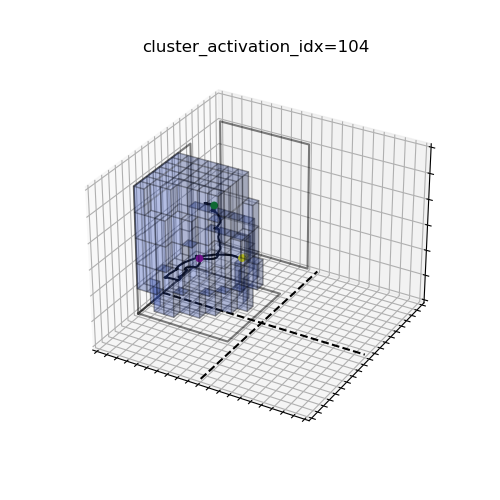

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
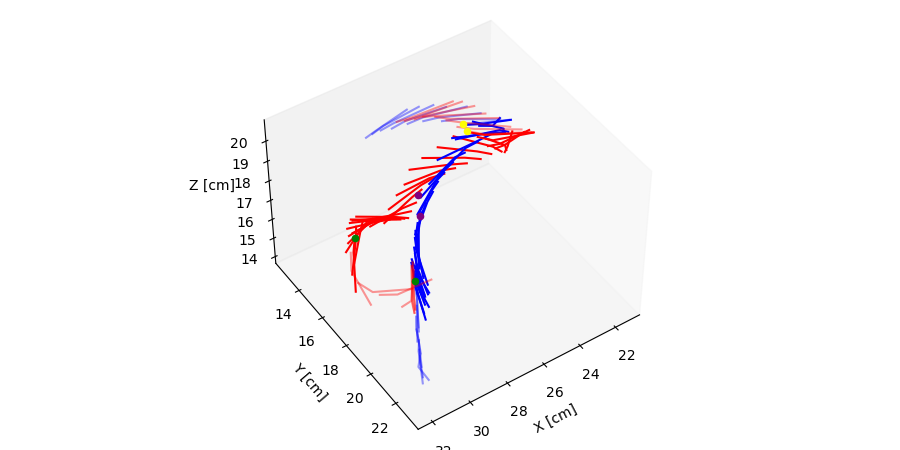

In [114]:
cluster_activation_idx = 104 #71

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 45 #15 #10
traj_azimuthal_angle = 56 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 30
state_space_azim = -60



# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)



# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='purple',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='yellow', s=20)

fig.tight_layout()





# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    ax.scatter(visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,2:], 
               color='purple', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='yellow', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(draw_axis)
fig.tight_layout()


#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_loser_attack_traj.png', dpi=300, transparent=True)


## plot all the possibilities

In [125]:


# # the gap between frames we will draw
# frame_gap = 5

# traj_elevation_angle = 45 #15 #10
# traj_azimuthal_angle = 56 #4

# frame_buf = 40 # the buffer in frames for the 3D plot

# # --- state-space plot params --- #
# state_space_elev = 30
# state_space_azim = -60



# # -----------------------------------------------------------------------------------------------------------------------------------#

# for cluster_activation_idx in activation_idx_choices_for_loser_attacks:

#     # parse the region data
#     reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
#     reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

#     # get the visualization 3D trajectory
#     reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

#     # get the state-space data
#     dpp = dpp_master[reg_f0:reg_fE]
#     theta_w = tetW_master[reg_f0:reg_fE]
#     theta_l = tetL_master[reg_f0:reg_fE]
#     region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

#     # get the voxel data for drawing the trajectory
#     region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
#                                                               dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
#                                                               tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
#                                                               tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

#     # make a list of frame indices
#     figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)



#     # ------------------------------------ (1) State-space plot ----------------------------------------------------#

#     fig = plt.figure(figsize=(5,5))

#     ax = fig.add_subplot(1,1,1, projection='3d')
#     ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
#     ax.view_init(state_space_elev, state_space_azim)
#     cluster_index_list = list(range(numClusters))
#     other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
#     # prepare some coordinates, based on the number of bins
#     x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#     #  Make the main voxel array 
#     voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
#     # set the colors of the background voxels 
#     colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
#     # the chosen cluster
#     cluster_voxels = cluster_state_tuples[clusterIdx]
#     cluster_col = loser_attack_color
#     num_cls_voxs = cluster_voxels.shape[0]
#     for voxIdx in range(num_cls_voxs):
#         vox = cluster_voxels[voxIdx]
#         colors[vox[0], vox[1], vox[2]] = cluster_col
#         voxelarray[vox[0], vox[1], vox[2]] = True
#     # now start the figure
#     ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#     #ax.set_xlabel(r'$\theta_{W}$')
#     #ax.set_ylabel(r'$\theta_{L}$')
#     #ax.set_zlabel(r'D$_{PP}$')
#     ax.set_xlim(0, num_tetW_bins)
#     ax.set_ylim(0, num_tetL_bins)
#     ax.set_zlim(0, num_dpp_bins)
#     ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
#     ax.set_xticklabels([]);
#     ax.set_xticks(np.arange(num_tetW_bins+1));
#     ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
#     ax.set_yticklabels([]);
#     ax.set_yticks(np.arange(num_tetL_bins+1));
#     ax.set_zticks(np.arange(num_dpp_bins+1));
#     ax.set_zticklabels([]);
#     #  Plot the projections of the cluster onto the walls 
#     min_x = np.min(cluster_voxels[:,0])
#     max_x = np.max(cluster_voxels[:,0])
#     min_y = np.min(cluster_voxels[:,1])
#     max_y = np.max(cluster_voxels[:,1])
#     min_z = np.min(cluster_voxels[:,2])
#     max_z = np.max(cluster_voxels[:,2])
#     # find the box for the XY plane
#     xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
#     xy_zs = [0, 0, 0, 0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
#     # find the box for the XZ plane
#     xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
#     xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
#     # find the box for the YZ plane
#     yz_xs = [0, 0, 0, 0, 0]
#     yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
#     yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

#     # ------------------------------------------------------------------#

#     ax.set_zlim(0, 6)

#     # plot the theta loser =0 line on bottom
#     xy_xs = [0, num_tetW_bins]
#     xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
#     xy_zs = [0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


#     # plot the theta winner = 0 extent line
#     xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
#     xy_ys = [0, num_tetW_bins]
#     xy_zs = [0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


#     # ----- plot the trajectory ---- #

#     xs =  region_voxel_data[:,1] #tetw
#     ys =  region_voxel_data[:,2] #tetl
#     zs =  region_voxel_data[:,0] #dpp
#     ax.plot(xs, ys, zs, color='black')

#     # ----- plot the start mid and end ---- #
#     xs =  region_voxel_data[0:2,1] #tetw
#     ys =  region_voxel_data[0:2,2] #tetl
#     zs =  region_voxel_data[0:2,0] #dpp
#     ax.scatter(xs, ys, zs, color='green',s=20)

#     xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
#     ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
#     zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
#     ax.scatter(xs, ys, zs, color='purple',s=20)

#     xs =  region_voxel_data[-2:,1] #tetw
#     ys =  region_voxel_data[-2:,2] #tetl
#     zs =  region_voxel_data[-2:,0] #dpp
#     ax.scatter(xs, ys, zs, color='yellow', s=20)

#     fig.tight_layout()





#     # ------------------------------------ (2) 3D plot  ----------------------------------------------------#



#     # --- make the figure -- #

#     fig = plt.figure(figsize=(9,4.5))
#     ax = fig.add_subplot(1, 1, 1, projection='3d')


#     fE = figure_fIdxs[-1]

#     # make the alphas for each frame
#     # in this case, we don't want to draw older frames more transparent,
#     # so the alpha for each frame results is simply one.
#     # But you can adjust the alpha values here if you like
#     alphas = np.ones((figure_fIdxs.shape[0]))

#     fish_colors = ['red', 'blue']


#     # draw the axes or not
#     draw_axis = True

#     ax.set_xlabel('X [cm]')
#     ax.set_ylabel('Y [cm]')
#     ax.zaxis.set_rotate_label(False)  # disable automatic rotation
#     ax.set_zlabel('Z [cm]', rotation=0)


#     # Provide starting angle for the view
#     ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



#     symbols = ['', '', '']
#     sizes=18

#     # ---------- scatter the main trajectories ------- #

#     for i,fIdx in enumerate(figure_fIdxs):
#         # Main lines
#         lines = []
#         for fishIdx in range(numFish):
#             col = fish_colors[fishIdx]
#             line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
#                            visualization_trajectories_master[fIdx, fishIdx, :, 1],
#                            visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
#             lines.append(line)


#     # ---- draw the first, mid and last markers ---- #

#     for fishIdx in range(numFish):
#         bpIdx = 0
#         ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
#                    visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
#                    visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
#                    color='green', s=20)
#         ax.scatter(visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,0:1], 
#                    visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,1:2], 
#                    visualization_trajectories_master[reg_f0+int(region_voxel_data.shape[0]/2), fishIdx,bpIdx,2:], 
#                    color='purple', s=20)
#         ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
#                    visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
#                    visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
#                    color='yellow', s=20)


#     # ---- draw the buffer frames ----- #

#     prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
#     post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

#     # plot these with alpha
#     buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

#     for i,fIdx in enumerate(prior_fIdxs):
#         prior_lines = []
#         for fishIdx in range(numFish):
#             col = fish_colors[fishIdx]
#             prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
#                                  visualization_trajectories_master[fIdx, fishIdx, :, 1],
#                                  visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
#             prior_lines.append(prior_line)

#     for i,fIdx in enumerate(post_fIdxs):
#         post_lines = []
#         for fishIdx in range(numFish):
#             col = fish_colors[fishIdx]
#             post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
#                                  visualization_trajectories_master[fIdx, fishIdx, :, 1],
#                                  visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
#             post_lines.append(post_line)


#     # ------ finish up -----------#
#     ax.grid(False)
#     ax.axis(draw_axis)
#     fig.tight_layout()
#     #fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_loser_attack_traj.png', dpi=300, transparent=True)

    
#     print()
#     print()
#     print()

## make the paper version

/tmp/ipykernel_1811553/3800191643.py:153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
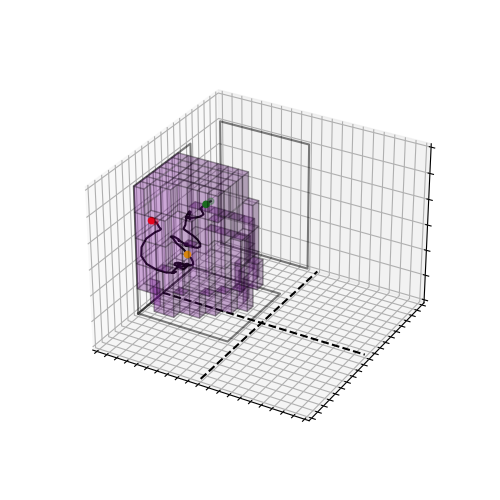

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
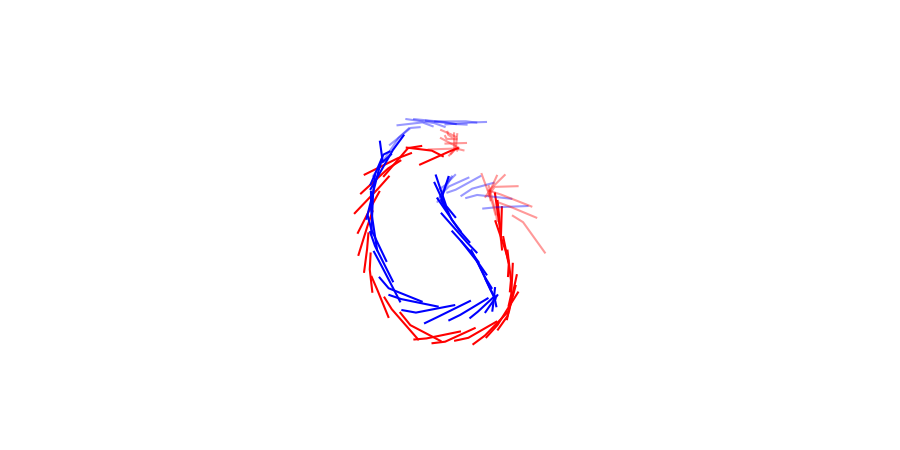

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
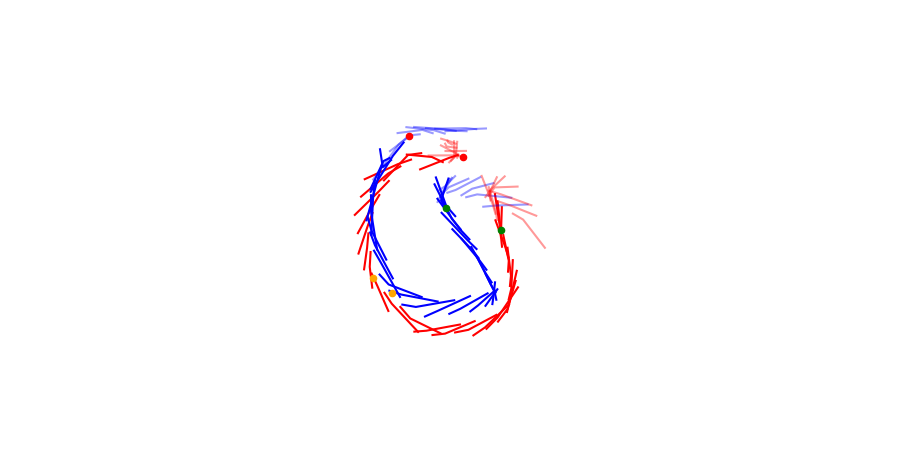

In [228]:
cluster_activation_idx = 120 #71

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 15 #15 #10
traj_azimuthal_angle = -113 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 30
state_space_azim = -60

state_space_plot_sp = '/home/liam/temp/image_transfer/fig5_loser_attack_3D_blue.png'
traj_plot_sp = '/home/liam/temp/image_transfer/fig5_loser_attack_traj.png'


# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)


# the marker point in the middle
orange_point_voxdata_idx = int(region_voxel_data.shape[0]/2) + 12
orange_point_fIdx = reg_f0 + orange_point_voxdata_idx


# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='orange',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='red', s=20)

fig.tight_layout()

fig.savefig(state_space_plot_sp, dpi=300, transparent=True)




# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()


fig.savefig(traj_plot_sp, dpi=300, transparent=True)






# ------------------------------------ (2) 3D no colored points  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    
    ax.scatter(visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,2:], 
               color='orange', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='red', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()



# Fig 5 Panel B - right top

In [229]:
# the master set of clusterIdx timeseries for N=10 states
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [230]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [235]:
# rename the dataset we are going to use, for ease
clIdx_dataset = np.copy(clusterIdx_edited_postProced_tseries_master)

In [236]:
def exp_fit(x,beta):
    #defining a decaying exponential function
    y = (1/beta)*np.exp(-x/beta)
    return y


# def exp_fit_with_const(x,beta,a):
#     #defining a decaying exponential function
#     y = a + (1/beta)*np.exp(-x/beta)
#     return y

In [237]:
# ---- get the cluster-type sizes ---- #
# get a bool array representing true for this clusterIdx
clIdx_boolarr = clIdx_dataset == clIdx
# get the contiguous regions of this bool array
cl_regions = contiguous_regions(clIdx_boolarr)
# get the size of the regions
cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)

In [238]:
# ---- get the cluster-type sizes ---- #

# set the cluster we are looking for
clIdx=2

# get a bool array representing true for this clusterIdx
clIdx_boolarr = clIdx_dataset == clIdx

# get the contiguous regions of this bool array
cl_regions = contiguous_regions(clIdx_boolarr)

# get the size of the regions
cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
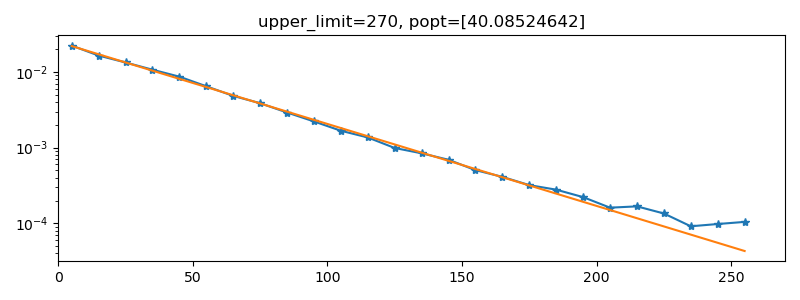

In [239]:
# --- set the bins ---#
# This is good, use again, but don't keep all the figures open for memory sake

bin0 = 10
binWidth = 10
binE = 280
occupancy_bins = np.arange(start=bin0, stop=binE, step=binWidth, dtype=int) 


    
# --- histogram --- #
hist, _ = np.histogram(cl_region_sizes, bins=occupancy_bins, density=True)

# --- fit --- #
# an array that contains the coordinate of the left edge of each bar
x = np.arange(0, binWidth*(occupancy_bins.shape[0]-1), binWidth)

# the point of the fit will be positioned at the center of the bins
x_fit  = x + x[1]/2 

# fit the exponential distribution,
popt , pcov  = curve_fit(exp_fit, x_fit, hist, p0=[38]) 

# building the y-array of the fitted exponential distribution
f_x_fit = exp_fit(x_fit, popt[0])

# ---- figure --- #
fig, axs = plt.subplots(ncols=1, figsize=(8,3))

plot_name = f'upper_limit={occupancy_bins[-1]}, popt={popt}'

ax = axs
ax.set_title(plot_name)
ax.plot(x_fit, hist, marker='*')
ax.plot(x_fit, f_x_fit)
ax.set_xlim(left=0, right=occupancy_bins[-1])
#ax.set_ylim(bottom=0, top=0.05)
ax.set_yscale('log')
fig.tight_layout()

## paper version

In [261]:
loser_attack_color

[0.5686274509803921, 0.11764705882352941, 0.7058823529411765, 0.2]

In [262]:
loser_attack_color_no_alpha = [0.5686274509803921, 0.11764705882352941, 0.7058823529411765, 1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
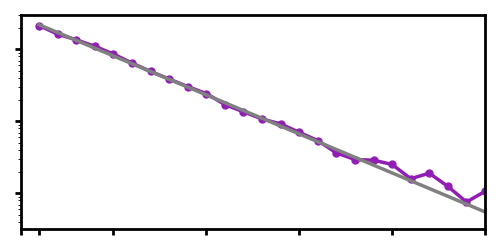

In [263]:
fig, axs = plt.subplots(ncols=1, figsize=(5,2.5))

# prepare the X array data for plotting (use the left bin edges)
X_plot_data_frames = occupancy_bins[:-1]
X_plot_data_secs = X_plot_data_frames / 100

ax = axs
ax.plot(X_plot_data_secs, hist, linewidth=2.5, marker='.', color=loser_attack_color_no_alpha, markersize=10)
ax.plot(X_plot_data_secs, f_x_fit, color='gray', linewidth=2.5, linestyle='-')
ax.set_xlim(left=0, right=2.5)
ax.set_yscale('log')
ax.set_xticks([0, 0.10, 0.5, 1, 1.5, 2, 2.5])

# ----------
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.legend(fontsize=10, frameon=False, markerscale=10, labelspacing=2, bbox_to_anchor=(0.6,0.9))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)
fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/fig5_B_dwell_time.png', dpi=300, transparent=True)

## bootstrapping 

In [ ]:
# we want to bootstrap over experiments

In [242]:
len(all_exps_edited_postProced_clusterIdx_tseries)

22

In [243]:

# number of bootstrapping resamples
n_resamples=1000  

# --------- #
t0 = time.perf_counter()

# number of experiments to bootstrap over
numSamples = len(all_exps_edited_postProced_clusterIdx_tseries)


# perform n_resamples number of trials
resample_exppec_vals = []
for i in range(n_resamples):
    
    #  get the fight indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    
    # get this resample data by concatenating all of the selected experiments for this resample
    resample_clIdx_dataset = np.concatenate([all_exps_edited_postProced_clusterIdx_tseries[i] for i in indices])

    # --------- get the region sizes ---------- #
    # get a bool array representing true 
    clIdx_boolarr = resample_clIdx_dataset == clIdx
    # get the contiguous regions of this bool array
    cl_regions = contiguous_regions(clIdx_boolarr)
    # get the size of the regions
    cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)
    
    # --- fit the exponential distribution and get expectation --- #
    # get a histogram of the cluster region sizes
    hist, _ = np.histogram(cl_region_sizes, bins=occupancy_bins, density=True)
    # fit the exponential distribution
    popt, pcov = curve_fit(exp_fit,x_fit,hist,p0=[38]) # calling the fit function
    # expectation value
    resample_expectation_val = popt[0]
    resample_exppec_vals.append(resample_expectation_val)
    
# --- finish up ---#
resample_exppec_vals = np.array(resample_exppec_vals)
    
tE = time.perf_counter()
print(tE-t0)

90.80197170004249


In [244]:
np.std(resample_exppec_vals)

1.5065063533676648

In [245]:
np.round(np.std(resample_exppec_vals))

2.0

# Fig 5 panel B - right bottom 

In [ ]:
# condition original clusters (n=56) on phi-dots

In [246]:
original_clusterIdx_postProced_tseries_master.shape

(16044324,)

In [247]:
# ---- Condition original clusters (n=56) on phi-dots ---- #

original_cluster_dppdots_master = []
original_cluster_phidots_master = []
for clusterIdx in range(numClusters):
    
    cluster_idx_frames_master = np.where(original_clusterIdx_postProced_tseries_master==clusterIdx)[0]
    
    cls_dppdots = dpp_dot_master[cluster_idx_frames_master]
    cls_phidots = phi_dot_master[cluster_idx_frames_master]

    original_cluster_dppdots_master.append(cls_dppdots)
    original_cluster_phidots_master.append(cls_phidots)
    

In [248]:
len(original_cluster_phidots_master)

56

In [249]:
# ---- get the phi-dots for the loser attack clusters --- #
# the loser attacks clusters in original cluster labelling were clusters 3 and 6
# (see post_processing_infomap_results.ipynb)

clusterIdx = 3 #loser right attack
loser_right_attack_phidots = np.copy(original_cluster_phidots_master[clusterIdx])

clusterIdx = 6 #loser left attack
loser_left_attack_phidots = np.copy(original_cluster_phidots_master[clusterIdx])

In [250]:
# --- set the bins we will use --- #
dpp_dots_bins = np.arange(-20,20+0.25,0.25)
phi_dots_bins = np.arange(-10,10+0.1,0.1)
pec_z_difference_bins = np.arange(-5,5+0.1,0.1)
Oz_dot_bins = np.arange(-10,10+0.1,0.1)

phi_dot_bins_widths = phi_dots_bins[1]-phi_dots_bins[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
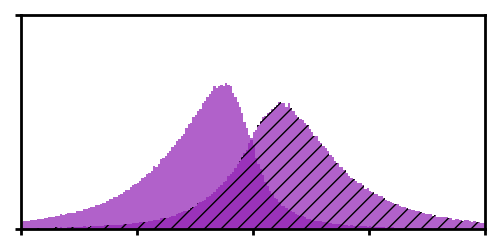

In [259]:
# -- plot the 4 histograms --- #

fig, axs = plt.subplots(figsize=(5,2.5), nrows=1)

# phi-dot
ax = axs
lra_histout = ax.hist(loser_right_attack_phidots, bins=phi_dots_bins,  alpha=0.7, color=loser_attack_color, density=True, label='         ');
lla_histout = ax.hist(loser_left_attack_phidots, bins=phi_dots_bins, density=True, alpha=0.7, color=loser_attack_color, label='          ', hatch='//');
ax.set_xlim(np.min(phi_dots_bins), np.max(phi_dots_bins))
ax.set_ylim(0,0.3)
#ax.legend(fontsize=8, frameon=False, labelspacing=2, bbox_to_anchor=(0.6,0.9))
ax.set_yticks([0, 0.3])
ax.set_yticklabels([])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_xticklabels([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout(h_pad=5)

fig.savefig('/home/liam/temp/image_transfer/fig5_B_phi_dots.png', dpi=300, transparent=True)

In [252]:
np.max(lra_histout[0])

0.20553579308053177

In [253]:
np.max(lra_histout[0])*phi_dot_bins_widths

0.020553579308053103

In [254]:
np.max(lla_histout[0])*phi_dot_bins_widths

0.01778449128264854

In [255]:
np.sum(lra_histout[0])*phi_dot_bins_widths

1.0

In [256]:
# so when controlling for bin_width the y-axis upper limit is
0.3*phi_dot_bins_widths

0.02999999999999989

# Fig 5 Panel C

We are going to follow the idea from fig5 B left and middle, only we shall only save the middle.

## winner left attack

/tmp/ipykernel_1811553/2788481578.py:154: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
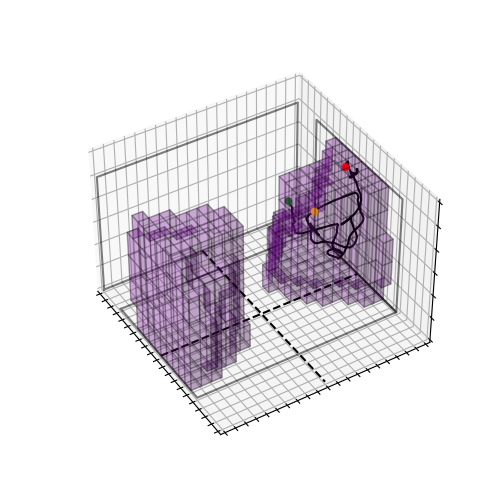

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
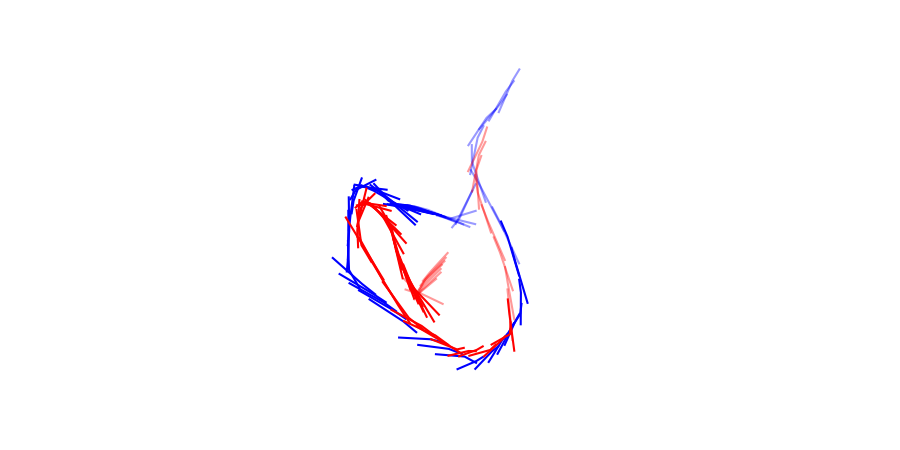

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
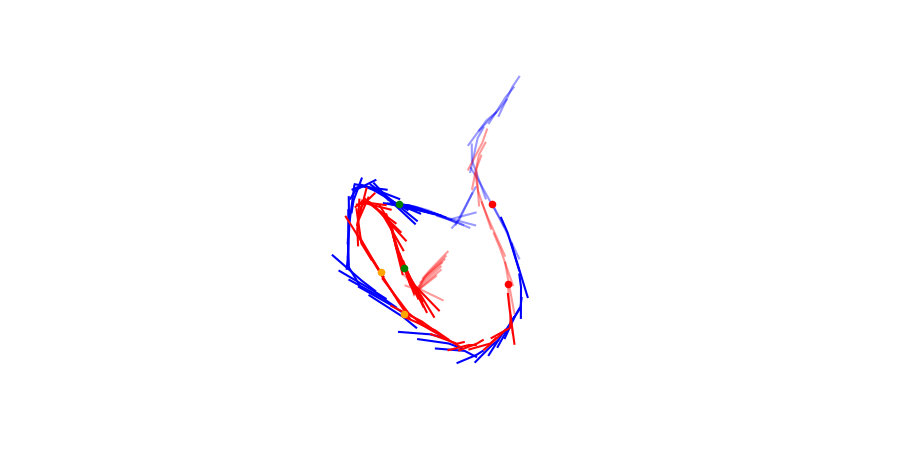

In [266]:
clusterIdx = 5

cluster_activation_idx = 1068 #71

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 36 #15 #10
traj_azimuthal_angle = -119 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 40
state_space_azim = -32

traj_plot_sp = '/home/liam/temp/image_transfer/fig5_C_winner_left_attack_traj.png'


# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)


# the marker point in the middle
orange_point_voxdata_idx = int(region_voxel_data.shape[0]/2) + 18
orange_point_fIdx = reg_f0 + orange_point_voxdata_idx


# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='orange',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='red', s=20)

fig.tight_layout()

#fig.savefig(state_space_plot_sp, dpi=300, transparent=True)




# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()


fig.savefig(traj_plot_sp, dpi=300, transparent=True)






# ------------------------------------ (2) 3D no colored points  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    
    ax.scatter(visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,2:], 
               color='orange', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='red', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()

## close circling

/tmp/ipykernel_1811553/2017306863.py:154: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
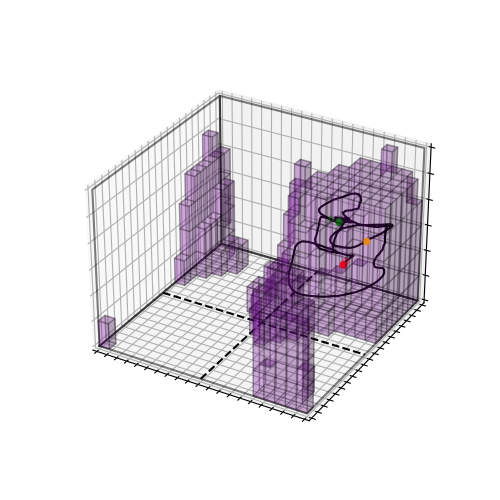

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
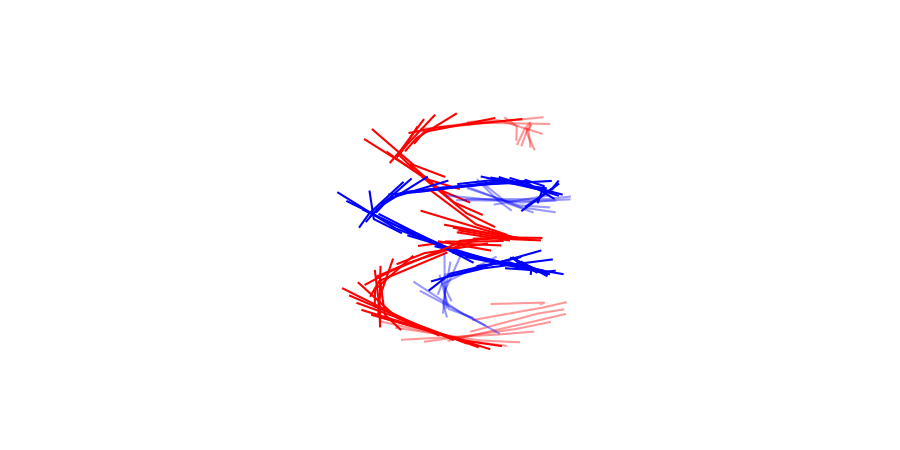

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
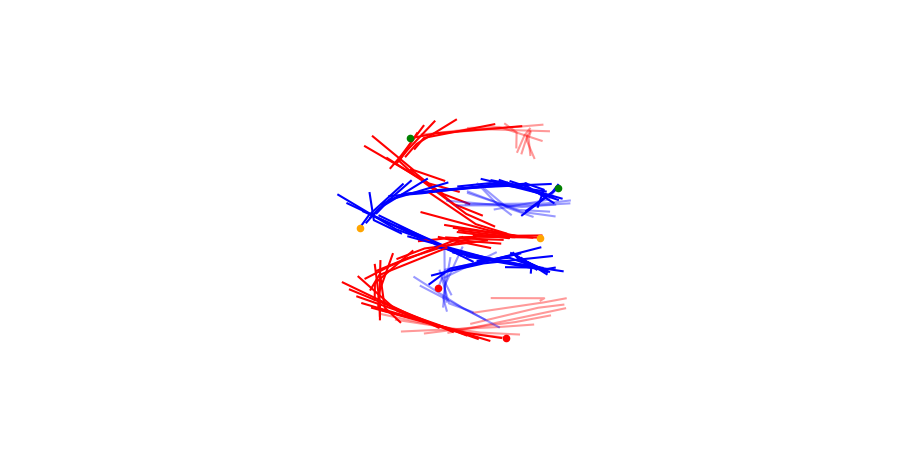

In [276]:

clusterIdx = 0 # or 1

cluster_activation_idx = 82 #82 #100 

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 21 #15 #10
traj_azimuthal_angle = 97 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 30
state_space_azim = -60

traj_plot_sp = '/home/liam/temp/image_transfer/fig5_C_close_circling_traj.png'


# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)


# the marker point in the middle
orange_point_voxdata_idx = int(region_voxel_data.shape[0]/2) - 18
orange_point_fIdx = reg_f0 + orange_point_voxdata_idx


# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='orange',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='red', s=20)

fig.tight_layout()

#fig.savefig(state_space_plot_sp, dpi=300, transparent=True)




# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()


fig.savefig(traj_plot_sp, dpi=300, transparent=True)






# ------------------------------------ (2) 3D no colored points  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    
    ax.scatter(visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,2:], 
               color='orange', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='red', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()

## display

/tmp/ipykernel_1811553/3585270154.py:154: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
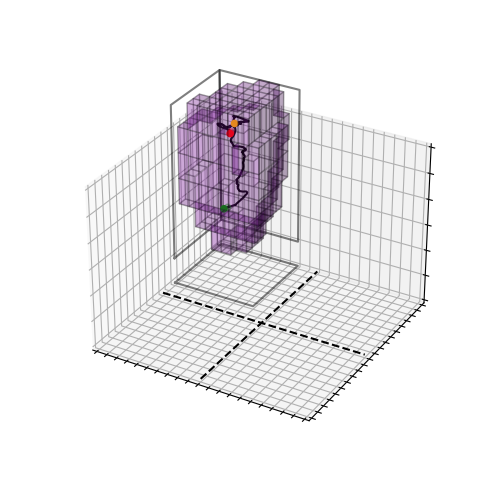

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
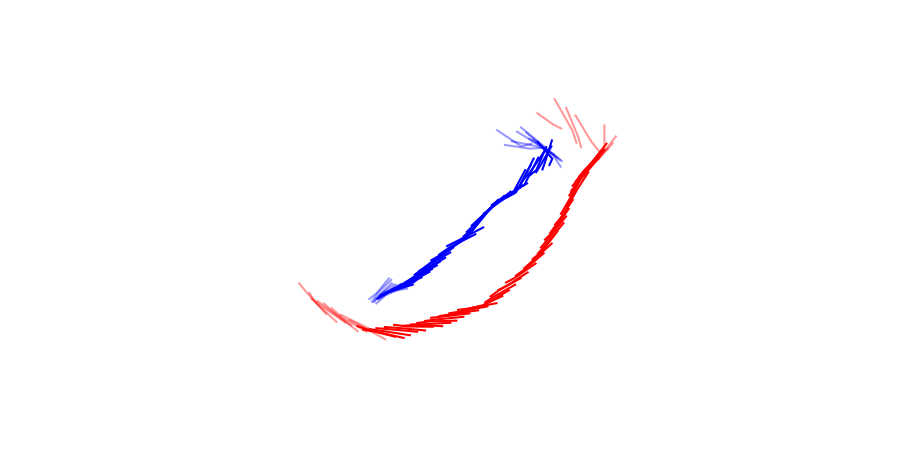

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
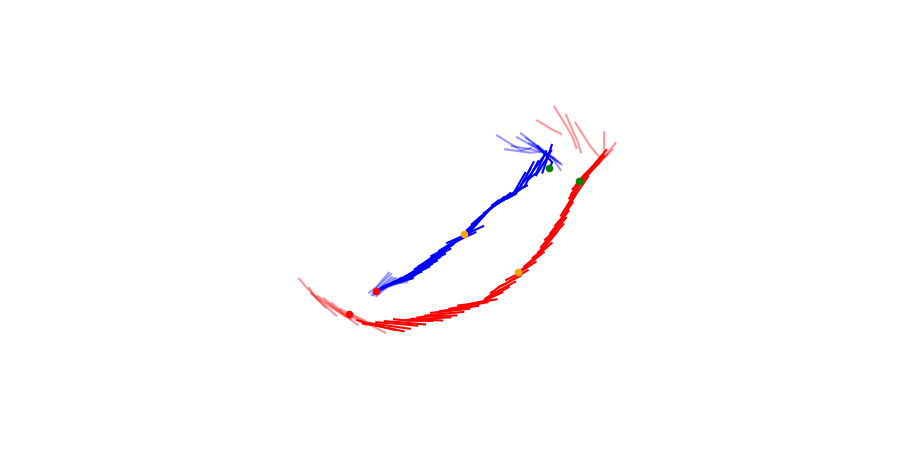

In [280]:

clusterIdx = 4 # or 11

cluster_activation_idx = 30 #71

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 31 #15 #10
traj_azimuthal_angle = 124 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 30
state_space_azim = -60

traj_plot_sp = '/home/liam/temp/image_transfer/fig5_C_display_traj.png'


# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)


# the marker point in the middle
orange_point_voxdata_idx = int(region_voxel_data.shape[0]/2) - 18
orange_point_fIdx = reg_f0 + orange_point_voxdata_idx


# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='orange',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='red', s=20)

fig.tight_layout()

#fig.savefig(state_space_plot_sp, dpi=300, transparent=True)




# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()


fig.savefig(traj_plot_sp, dpi=300, transparent=True)






# ------------------------------------ (2) 3D no colored points  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    
    ax.scatter(visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,2:], 
               color='orange', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='red', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()

## direct towards

/tmp/ipykernel_1811553/3538868913.py:154: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
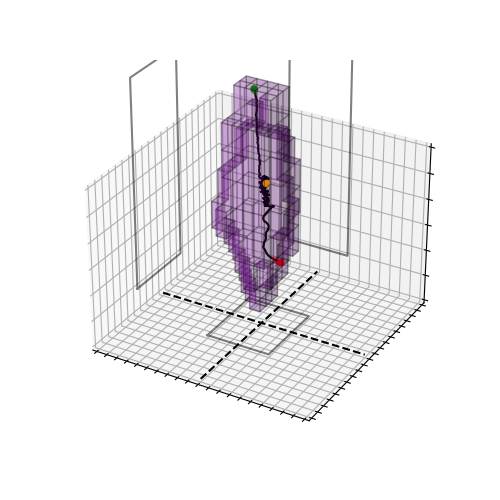

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
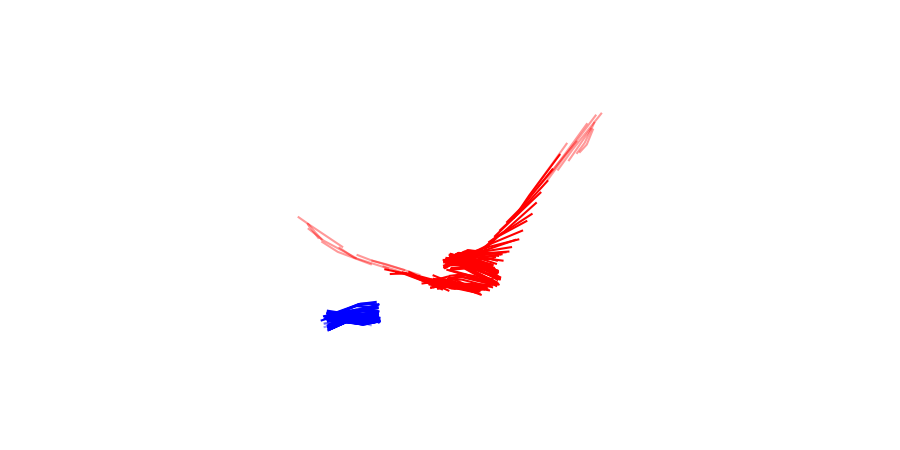

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
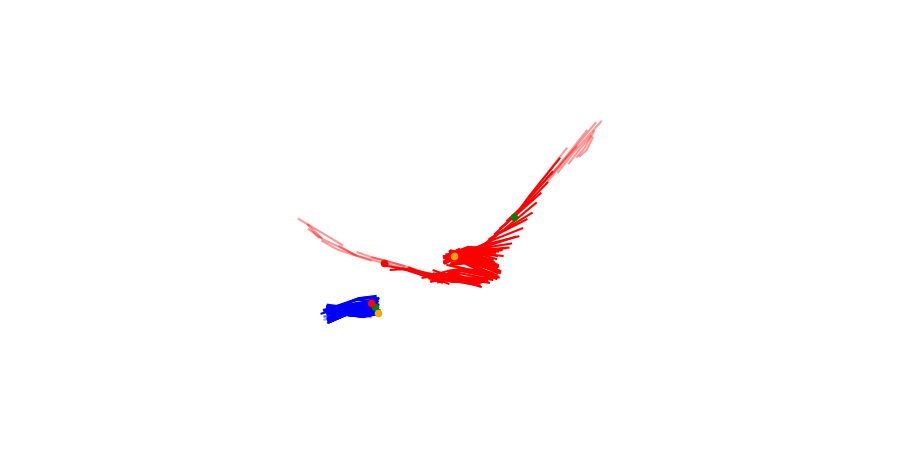

In [281]:

clusterIdx = 9

cluster_activation_idx = 65 #71

# the gap between frames we will draw
frame_gap = 5

traj_elevation_angle = 23 #15 #10
traj_azimuthal_angle = -63 #4

frame_buf = 40 # the buffer in frames for the 3D plot


# --- state-space plot params --- #
state_space_elev = 30
state_space_azim = -60

traj_plot_sp = '/home/liam/temp/image_transfer/fig5_C_direct_towards_traj.png'


# -----------------------------------------------------------------------------------------------------------------------------------#

# parse the region data
reg_size = original_clusterIdx_reg_sizes[clusterIdx][cluster_activation_idx]
reg_f0, reg_fE = original_clusterIdx_reg_framesRanges[clusterIdx][cluster_activation_idx]

# get the visualization 3D trajectory
reg_3D_trajectory = visualization_trajectories_master[reg_f0:reg_fE]

# get the state-space data
dpp = dpp_master[reg_f0:reg_fE]
theta_w = tetW_master[reg_f0:reg_fE]
theta_l = tetL_master[reg_f0:reg_fE]
region_state_data = np.stack([dpp, theta_w, theta_l], axis=1)

# get the voxel data for drawing the trajectory
region_voxel_data = convert_state_data_to_voxel_positions(region_state_data, 
                                                          dpp_binStart=dpp_bins[0], dpp_binStop=dpp_bins[-1], dpp_numbins=num_dpp_bins,
                                                          tetW_binStart=tet_w_bins[0], tetW_binStop=tet_w_bins[-1], tetW_numbins=num_tetW_bins, 
                                                          tetL_binStart=tet_l_bins[0], tetL_binStop=tet_l_bins[-1], tetL_numbins=num_tetL_bins)

# make a list of frame indices
figure_fIdxs = np.arange(reg_f0, reg_fE, frame_gap)


# the marker point in the middle
orange_point_voxdata_idx = int(region_voxel_data.shape[0]/2) - 18
orange_point_fIdx = reg_f0 + orange_point_voxdata_idx


# ------------------------------------ (1) State-space plot ----------------------------------------------------#

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_title(f'cluster_activation_idx={cluster_activation_idx}')
ax.view_init(state_space_elev, state_space_azim)
cluster_index_list = list(range(numClusters))
other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#  Make the main voxel array 
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
# set the colors of the background voxels 
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
# the chosen cluster
cluster_voxels = cluster_state_tuples[clusterIdx]
cluster_col = loser_attack_color
num_cls_voxs = cluster_voxels.shape[0]
for voxIdx in range(num_cls_voxs):
    vox = cluster_voxels[voxIdx]
    colors[vox[0], vox[1], vox[2]] = cluster_col
    voxelarray[vox[0], vox[1], vox[2]] = True
# now start the figure
ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.2]); #'k'
#ax.set_xlabel(r'$\theta_{W}$')
#ax.set_ylabel(r'$\theta_{L}$')
#ax.set_zlabel(r'D$_{PP}$')
ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)
ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([]);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([]);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([]);
#  Plot the projections of the cluster onto the walls 
min_x = np.min(cluster_voxels[:,0])
max_x = np.max(cluster_voxels[:,0])
min_y = np.min(cluster_voxels[:,1])
max_y = np.max(cluster_voxels[:,1])
min_z = np.min(cluster_voxels[:,2])
max_z = np.max(cluster_voxels[:,2])
# find the box for the XY plane
xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
xy_zs = [0, 0, 0, 0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', alpha=0.5)
# find the box for the XZ plane
xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(xz_xs, xz_ys, xz_zs, color='black', alpha=0.5)
# find the box for the YZ plane
yz_xs = [0, 0, 0, 0, 0]
yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
ax.plot(yz_xs, yz_ys, yz_zs, color='black', alpha=0.5)

# ------------------------------------------------------------------#

ax.set_zlim(0, 6)

# plot the theta loser =0 line on bottom
xy_xs = [0, num_tetW_bins]
xy_ys = [ num_tetW_bins/2,  num_tetW_bins/2]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# plot the theta winner = 0 extent line
xy_xs = [num_tetW_bins/2, num_tetW_bins/2]
xy_ys = [0, num_tetW_bins]
xy_zs = [0, 0]
ax.plot(xy_xs, xy_ys, xy_zs, color='black', linestyle='--')


# ----- plot the trajectory ---- #

xs =  region_voxel_data[:,1] #tetw
ys =  region_voxel_data[:,2] #tetl
zs =  region_voxel_data[:,0] #dpp
ax.plot(xs, ys, zs, color='black')

# ----- plot the start mid and end ---- #
xs =  region_voxel_data[0:2,1] #tetw
ys =  region_voxel_data[0:2,2] #tetl
zs =  region_voxel_data[0:2,0] #dpp
ax.scatter(xs, ys, zs, color='green',s=20)

xs =  region_voxel_data[int(region_voxel_data.shape[0]/2),1] #tetw
ys =  region_voxel_data[int(region_voxel_data.shape[0]/2),2] #tetl
zs =  region_voxel_data[int(region_voxel_data.shape[0]/2),0] #dpp
ax.scatter(xs, ys, zs, color='orange',s=20)

xs =  region_voxel_data[-2:,1] #tetw
ys =  region_voxel_data[-2:,2] #tetl
zs =  region_voxel_data[-2:,0] #dpp
ax.scatter(xs, ys, zs, color='red', s=20)

fig.tight_layout()

#fig.savefig(state_space_plot_sp, dpi=300, transparent=True)




# ------------------------------------ (2) 3D plot  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()


fig.savefig(traj_plot_sp, dpi=300, transparent=True)






# ------------------------------------ (2) 3D no colored points  ----------------------------------------------------#



# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((figure_fIdxs.shape[0]))

fish_colors = ['red', 'blue']


# draw the axes or not
draw_axis = True

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
ax.view_init(traj_elevation_angle, traj_azimuthal_angle)



symbols = ['', '', '']
sizes=18

# ---------- scatter the main trajectories ------- #

for i,fIdx in enumerate(figure_fIdxs):
    # Main lines
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                       visualization_trajectories_master[fIdx, fishIdx, :, 1],
                       visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=alphas[i])[0]
        lines.append(line)


# ---- draw the first, mid and last markers ---- #

for fishIdx in range(numFish):
    bpIdx = 0
    ax.scatter(visualization_trajectories_master[reg_f0,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_f0,fishIdx,bpIdx,2:], 
               color='green', s=20)
    
    ax.scatter(visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[orange_point_fIdx, fishIdx,bpIdx,2:], 
               color='orange', s=20)
    ax.scatter(visualization_trajectories_master[reg_fE,fishIdx,bpIdx,0:1], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,1:2], 
               visualization_trajectories_master[reg_fE,fishIdx,bpIdx,2:], 
               color='red', s=20)

    
# ---- draw the buffer frames ----- #

prior_fIdxs = np.arange((reg_f0-frame_buf), (reg_f0), frame_gap)
post_fIdxs = np.arange(reg_fE, (reg_fE+frame_buf), frame_gap)

# plot these with alpha
buf_alphas = np.ones((prior_fIdxs.shape[0]))*0.4

for i,fIdx in enumerate(prior_fIdxs):
    prior_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        prior_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        prior_lines.append(prior_line)
        
for i,fIdx in enumerate(post_fIdxs):
    post_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        post_line = ax.plot(visualization_trajectories_master[fIdx, fishIdx, :, 0], 
                             visualization_trajectories_master[fIdx, fishIdx, :, 1],
                             visualization_trajectories_master[fIdx, fishIdx, :, 2], c=col, alpha=buf_alphas[i])[0]
        post_lines.append(post_line)


# ------ finish up -----------#
ax.grid(False)
ax.axis(False)
fig.tight_layout()

# SI 8  panel A

To make the figure, we are going to load results that were computed on the Okinawa Institute of Science & Technology cluster.

See the folder called "tau_sweep" in "figures_code", for how this data was created.

In [368]:
mainloadfolder = '/media/liam/hd1/fighting_data/infomap_tau_sweep_data/'

In [361]:
# --- prepare the filepaths for reading the results of the analysis for each tau ---- #

tau_results_loadpaths = glob.glob(mainloadfolder+'dpp_choice_2/*/*infomap.h5')
tau_ext_nums = []
for fp in tau_results_loadpaths:
    tauext = fp.split('/')[-2]
    tau_num = int(tauext.split('_')[-1])
    tau_ext_nums.append(tau_num)
# now sort the filepaths using the tau_ext_nums correct ordering
tau_ext_nums, tau_results_loadpaths = zip(*sorted(zip(tau_ext_nums, tau_results_loadpaths)))

tau_ext_nums = list(tau_ext_nums)
tau_results_loadpaths = list(tau_results_loadpaths)



# ---- get the number of states used for discr ------#
with h5py.File(tau_results_loadpaths[0], 'r') as hf:
    dppbins = hf['dpp_bins'][:]
    tetwbins = hf['tet_w_bins'][:]
    tetlbins = hf['tet_l_bins'][:]
numdppbins = dppbins.shape[0] - 1
numtetwbins = tetwbins.shape[0] - 1
numtetlbins = tetlbins.shape[0] - 1
nstates = numdppbins*numtetwbins*numtetlbins


## numClusters panel

In [362]:
# ---- get the data needed ------#
eigval_list = []
tau_list = []
numClusters_list = []
numResults = len(tau_results_loadpaths)
for fp in tau_results_loadpaths:
    with h5py.File(fp, 'r') as hf:
        eigvals = hf['sorted_eig_vals'][:]
        tau = hf['tau'][()]
        numClusters = hf['numClusters'][()]
        eigval_list.append(eigvals)
        tau_list.append(tau)
        numClusters_list.append(numClusters)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
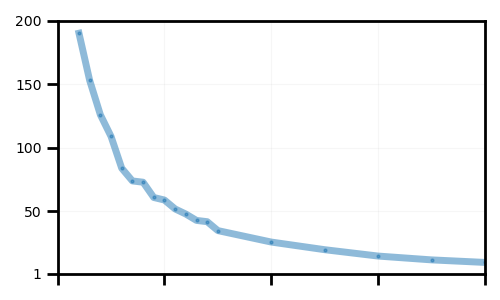

In [363]:
fig, axs = plt.subplots(figsize=(5,3))

ax = axs


ax.plot(tau_list, numClusters_list, alpha=0.5, label=label, linewidth=5, marker='o', markersize=2)

ax.set_xticks(tau_list);

ax.set_yticks([1] + [i for i in range(0,210,50)])

ax.set_xticks([0, 10, 20, 30, 40])
ax.set_ylim(1, 200)
ax.set_xlim(0,40)
ax.grid(alpha=0.1)

ax.set_xticklabels([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)

#ax.legend()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
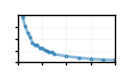

In [364]:
fig, axs = plt.subplots(figsize=(1.3,0.8))

ax = axs

ax.plot(tau_list, numClusters_list, alpha=0.5, label=label, linewidth=2, marker='o', markersize=2)

ax.set_xticks(tau_list);

ax.set_yticks([1] + [i for i in range(0,160,50)])

ax.set_xticks([0, 10, 20, 30, 40])
ax.set_ylim(1, 200)
ax.set_xlim(0,40)
ax.grid(alpha=0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)

#ax.legend()
fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/figS8_numClusters.png', dpi=300, transparent=True)

## volume fraction panel

In [365]:
# --- get the size of each cluster as a percentage of total volume --- #
t0 = time.time()



tau_list_cluster_sizes_percens = []
tau_list_cluster_sizes_percens_maxs = []
for tau_idx in range(len(choice_tau_lists[cIdx])):

    # ---- load some clustering info ------ #
    resultsPath = tau_results_loadpaths[tau_idx]
    with h5py.File(resultsPath, 'r') as hf:
        numClusters = hf['numClusters'][()]

    cluster_state_tuples = []
    with h5py.File(resultsPath, 'r') as hf:
        for clusterIdx in range(numClusters):
            st_tups = hf['cluster_state_tuples/cluster{0}'.format(clusterIdx)][:]
            cluster_state_tuples.append(st_tups)

    # ---- get the size of each cluster (in number of voxels) --- #
    cluster_num_voxels = np.zeros((numClusters,))
    for clusterIdx in range(numClusters):
        cluster_num_voxels[clusterIdx] = cluster_state_tuples[clusterIdx].shape[0]


    # --- get the size of each cluster as a percentage of total volume -- #
    cluster_sizes_percen = (cluster_num_voxels / nstates)*100

    tau_list_cluster_sizes_percens.append(cluster_sizes_percen)
    tau_list_cluster_sizes_percens_maxs.append(np.max(cluster_sizes_percen))
        


print(time.time()-t0)

0.2960808277130127


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
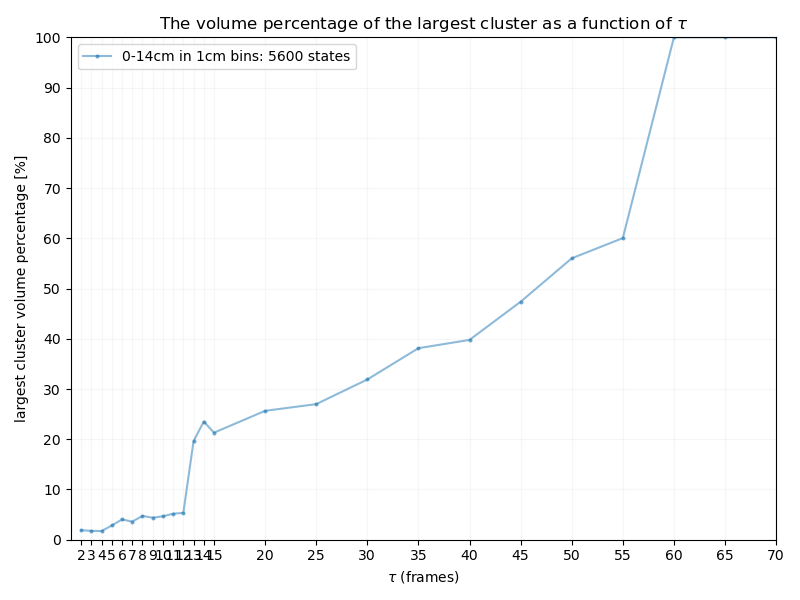

In [366]:
fig, axs = plt.subplots(figsize=(8,6))

ax = axs


#largest_cluster_size_percent_list = choice_tau_list_cluster_sizes_percens_maxs[cIdx]


ax.plot(tau_list, tau_list_cluster_sizes_percens_maxs, alpha=0.5, label=label, marker='o', markersize=2)

ax.set_xticks(tau_list);
ax.set_title('The volume percentage of the largest cluster as a function of ' + r'$\tau$')
ax.set_xlabel(r"$\tau$ (frames)")
ax.set_ylabel('largest cluster volume percentage [%]')
ax.set_yticks([i for i in range(0,110,10)])
#ax.set_xticks([1] + [i for i in tau_list])
ax.set_ylim(0, 100)
ax.set_xlim(1,70)
ax.grid(alpha=0.1)

ax.legend()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
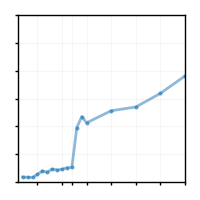

In [367]:
fig, axs = plt.subplots(figsize=(2,2))

ax = axs

ax.plot(tau_list, tau_list_cluster_sizes_percens_maxs, alpha=0.5, linewidth=2, marker='o', markersize=2)

ax.set_xticks(tau_list);
ax.set_title('')
ax.set_xlabel("")
ax.set_ylabel('')
ax.set_yticks([i for i in range(0,70,10)])
ax.set_xticks([0,5,10,12,15,20,25,30,35])
ax.set_ylim(0, 60)
ax.set_xlim(1, 35)
ax.grid(alpha=0.1)
ax.set_xticklabels([])
ax.set_yticklabels([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)

fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/figS8_volume_fraction.png', dpi=300, transparent=True)

# -----------------------------#

## largest cluster volume

In [292]:
# --- get the size of each cluster as a percentage of total volume --- #
t0 = time.time()


choice_tau_list_cluster_sizes_percens = []
choice_tau_list_cluster_sizes_percens_maxs = []


for cIdx in range(1):


    tau_list_cluster_sizes_percens = []
    tau_list_cluster_sizes_percens_maxs = []
    for tau_idx in range(len(choice_tau_lists[cIdx])):

        # ---- load some clustering info ------ #
        resultsPath = choice_loadpath_list[cIdx][tau_idx]
        with h5py.File(resultsPath, 'r') as hf:
            tseries = hf['tseries'][:]
            #ransition_matrix = hf['transition_matrix'][:]
            tet_w_bins = hf['tet_w_bins'][:]
            tet_l_bins = hf['tet_l_bins'][:]
            dpp_bins = hf['dpp_bins'][:]
            numClusters = hf['numClusters'][()]

        cluster_state_tuples = []
        cluster_state_idxs = []
        with h5py.File(resultsPath, 'r') as hf:
            for clusterIdx in range(numClusters):
                st_idxs = hf['cluster_state_idxs/cluster{0}'.format(clusterIdx)][:]
                st_tups = hf['cluster_state_tuples/cluster{0}'.format(clusterIdx)][:]
                cluster_state_idxs.append(st_idxs)
                cluster_state_tuples.append(st_tups)

        num_tetW_bins = tet_w_bins.shape[0]-1
        num_tetL_bins = tet_l_bins.shape[0]-1
        num_dpp_bins = dpp_bins.shape[0]-1
        numStates = num_tetW_bins*num_tetL_bins*num_dpp_bins
        binTuple_to_clusterIdx_dict = make_binTuple_to_clusterIdx_dict(cluster_state_tuples)



        # ---- get the size of each cluster (in number of voxels) --- #
        cluster_num_voxels = np.zeros((numClusters,))
        for clusterIdx in range(numClusters):
            cluster_num_voxels[clusterIdx] = cluster_state_tuples[clusterIdx].shape[0]


        # --- get the size of each cluster as a percentage of total volume -- #
        cluster_sizes_percen = (cluster_num_voxels / choice_numState_list[cIdx])*100

        tau_list_cluster_sizes_percens.append(cluster_sizes_percen)
        tau_list_cluster_sizes_percens_maxs.append(np.max(cluster_sizes_percen))
        
        
    # --- record for this binning --- #
    choice_tau_list_cluster_sizes_percens.append(tau_list_cluster_sizes_percens)
    choice_tau_list_cluster_sizes_percens_maxs.append(tau_list_cluster_sizes_percens_maxs)

print(time.time()-t0)

20.217223405838013


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
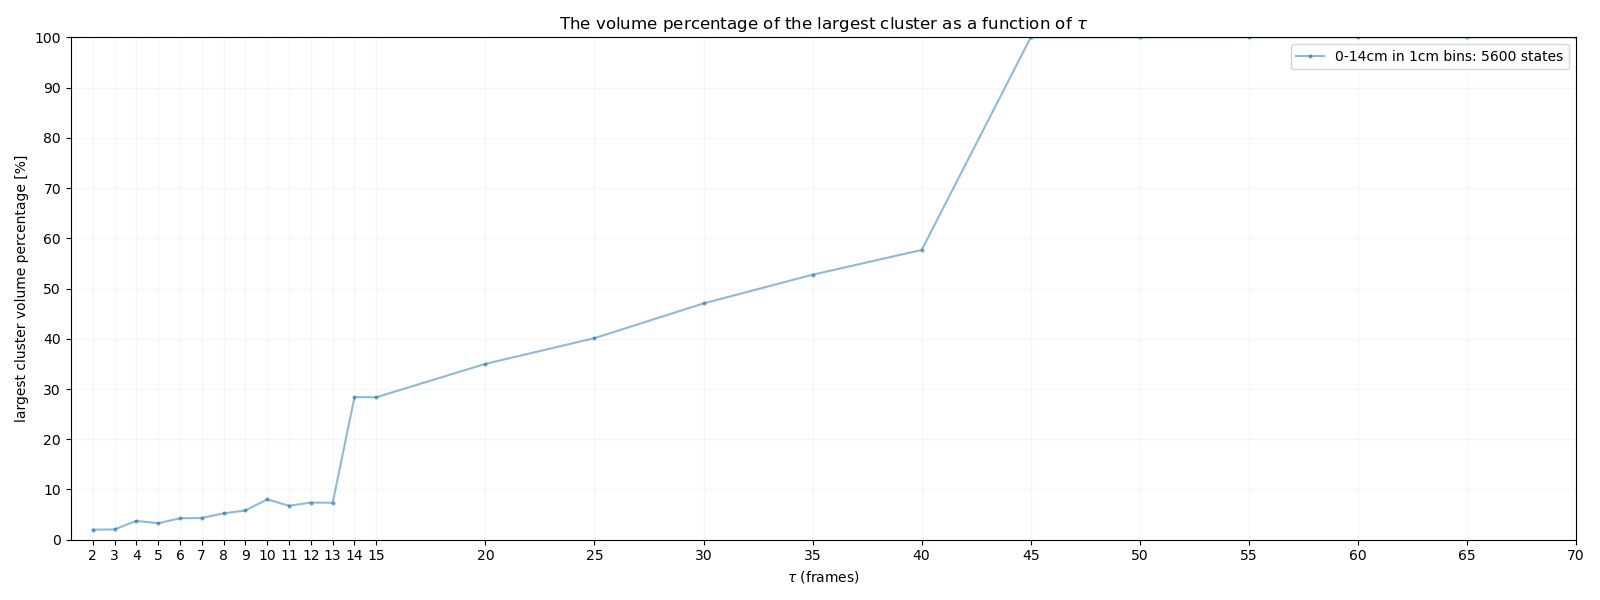

In [293]:
fig, axs = plt.subplots(figsize=(16,6))

ax = axs

for cIdx in range(1):
    
    label = dpp_choices[cIdx] + ': {0} states'.format(choice_numState_list[cIdx])
    tau_list = choice_tau_lists[cIdx]
    largest_cluster_size_percent_list = choice_tau_list_cluster_sizes_percens_maxs[cIdx]

    
    ax.plot(tau_list, largest_cluster_size_percent_list, alpha=0.5, label=label, marker='o', markersize=2)

ax.set_xticks(tau_list);
ax.set_title('The volume percentage of the largest cluster as a function of ' + r'$\tau$')
ax.set_xlabel(r"$\tau$ (frames)")
ax.set_ylabel('largest cluster volume percentage [%]')
ax.set_yticks([i for i in range(0,110,10)])
#ax.set_xticks([1] + [i for i in tau_list])
ax.set_ylim(0, 100)
ax.set_xlim(1,70)
ax.grid(alpha=0.1)

ax.legend()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
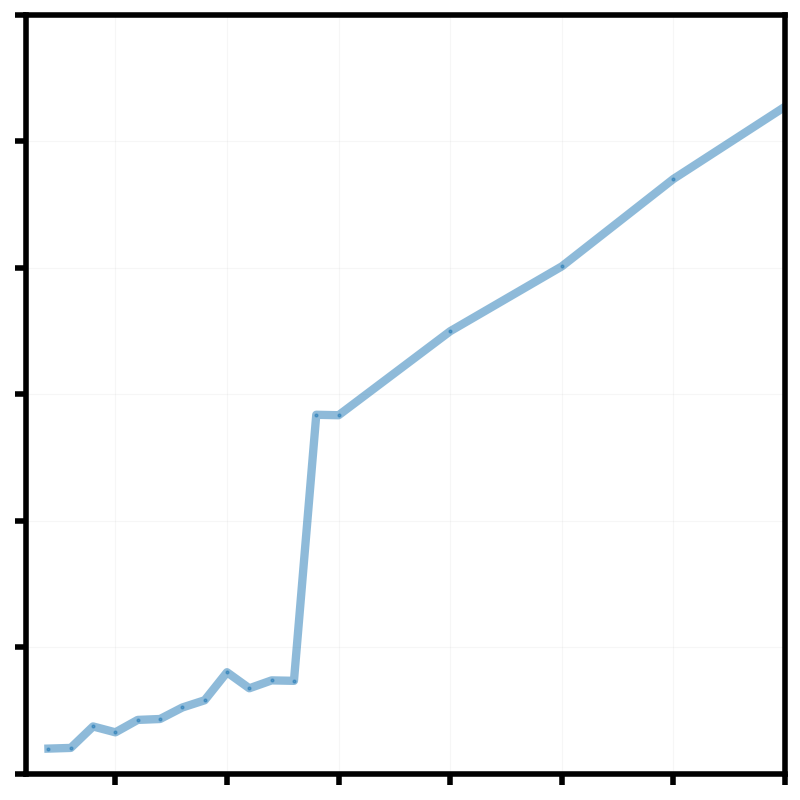

In [294]:
fig, axs = plt.subplots(figsize=(8,8))

ax = axs

for cIdx in range(1):
    
    label = dpp_choices[cIdx] + ': {0} states'.format(choice_numState_list[cIdx])
    tau_list = choice_tau_lists[cIdx]
    largest_cluster_size_percent_list = choice_tau_list_cluster_sizes_percens_maxs[cIdx]

    
    ax.plot(tau_list, largest_cluster_size_percent_list, alpha=0.5, label=label, linewidth=6, marker='o', markersize=2)

ax.set_xticks(tau_list);
#ax.set_title('The volume percentage of the largest cluster as a function of ' + r'$\tau$')
#ax.set_xlabel(r"$\tau$ (frames)")
#ax.set_ylabel('largest cluster volume percentage [%]')
ax.set_yticks([i for i in range(0,70,10)])
ax.set_xticks([0,5,10,15,20,25,30,35])
#ax.set_xticks([1] + [i for i in tau_list])
ax.set_ylim(0, 60)
ax.set_xlim(1,35)
ax.grid(alpha=0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.xaxis.set_tick_params(width=4, length=8)
ax.yaxis.set_tick_params(width=4, length=8)

#ax.legend()
fig.tight_layout()

# SI 8 panel B

See the processing_infomap_results.ipynb notebook

# SI 8 panel C

In [ ]:
original_cluster_idxs

In [ ]:
original_cluster_idxs.shape

In [282]:

# --- special colors ----- #
#
# We don't want this figure to have exactly the same colorscheme as the other figures of this nature,
# because in all the other figures, we have combined into 10 states already. Here, we are showing
# the originally chosen 16 clusters, so the colorschemes have no relation really. 

expanded_colorlist = ['#ffe119', '#3cb44b', '#e6194B', '#4363d8', '#f58231', 
                      '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
                      '#469990', '#dcbeff', '#9A6324', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 

alpha_val_1 = 0.4
orig_cluster_used_colors = [ [0,0,0,0] for i in range(original_cluster_idxs.shape[0]) ]
for clIdx in range(original_cluster_idxs.shape[0]):
    # imported from matplotlib colors to_rgb
    col = to_rgb(expanded_colorlist[clIdx])
    orig_cluster_used_colors[clIdx][0] = col[0]
    orig_cluster_used_colors[clIdx][1] = col[1]
    orig_cluster_used_colors[clIdx][2] = col[2]
    orig_cluster_used_colors[clIdx][3] = alpha_val_1

/tmp/ipykernel_1811553/1937510352.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
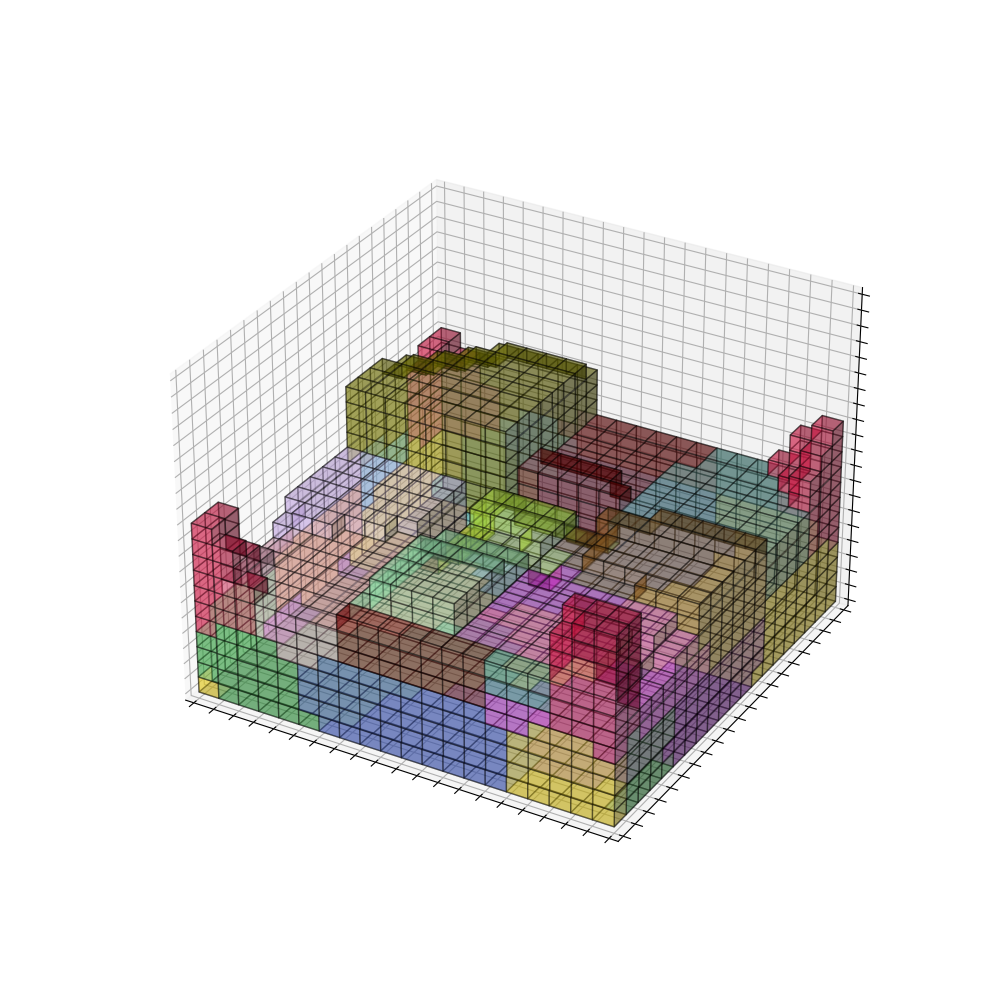

In [283]:
# prepare some info
imsavepath = os.path.join('/home/liam/temp/image_transfer/figS8_C.png')

# prepare some coordinates, based on the number of bins
x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))

# --- Make the main voxel array --- #
voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)

# --- set the colors of the background voxels --- #
colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)

# draw all the voxels for each cluster
for ii, origClIdx in enumerate(original_cluster_idxs):
    
    #i = used_original_clusterIdxs[ii]
    cluster_voxels = cluster_state_tuples[origClIdx]
    cluster_col = orig_cluster_used_colors[ii]
    num_cls_voxs = cluster_voxels.shape[0]
    for voxIdx in range(num_cls_voxs):
        vox = cluster_voxels[voxIdx]
        colors[vox[0], vox[1], vox[2]] = cluster_col
        voxelarray[vox[0], vox[1], vox[2]] = True

# ----- plot everything ----------#
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.voxels(voxelarray, facecolors=colors, edgecolor=[0,0,0,0.4]);  #edgecolor='k'

ax.set_xlabel('', fontsize=24)
ax.set_ylabel('', fontsize=24)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('', fontsize=24, rotation=90)

ax.set_xlim(0, num_tetW_bins)
ax.set_ylim(0, num_tetL_bins)
ax.set_zlim(0, num_dpp_bins)

ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
ax.set_xticklabels([], fontsize=16);
ax.set_xticks(np.arange(num_tetW_bins+1));
ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
ax.set_yticklabels([], fontsize=16);
ax.set_yticks(np.arange(num_tetL_bins+1));
ax.set_zticks(np.arange(num_dpp_bins+1));
ax.set_zticklabels([], fontsize=16);

# increase the spacing between axes labels and figure
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

 # save the image
dpi = 300
fig.tight_layout()
#fig.savefig(imsavepath, dpi=dpi, transparent=True, pad_inches=0)

# SI 9

In [ ]:
# we use the same colorlist as fig 6B, etc, where we have N=10 states
colorlist



In [ ]:
# plot them in the same order as we did figure 6
new_plot_order = [2,3,0,4,8,7,1,5,6,9,10]

# but we will not be plotting the last plot - nonFight clusters.
new_plot_order = new_plot_order[:-1]

# a dcionary which maps state indexs to the row i want to draw them
plotNum_to_editedClIdx_dict = dict(zip(new_plot_order, np.arange(0, numLabelledStates)))

for edited_clusterIdx, plotIdx in plotNum_to_editedClIdx_dict.items():
    print(f'plotIdx={plotIdx}, edited_clusterIdx={edited_clusterIdx}')

In [ ]:
# for edited_clusterIdx, plotIdx in plotNum_to_editedClIdx_dict.items():
    
#     # get the original cluster labels that went into making this edited clusterIdx.
#     # can be 1 or more old cluster labels
#     old_idxs_row_indices = np.where(np.array(edited_cluster_idxs) == edited_clusterIdx)[0]
#     old_clusterIdxs = np.array(original_cluster_idxs)[old_idxs_row_indices]
    
#     # the voxels for the edited clusterIdx
#     cluster_voxels = np.concatenate([cluster_state_tuples[clusterIdx] for clusterIdx in old_clusterIdxs], axis=0)
    
    
#     # -------------------------------------#

#     fig = plt.figure(figsize=(5,5))

#     ax = fig.add_subplot(1,1,1, projection='3d')
    
#     ax.set_title(state_names[edited_clusterIdx])

#     elev = 30
#     azim = -60
#     ax.view_init(elev, azim)
#     cluster_index_list = list(range(numClusters))
#     other_cluster_idxs = [x for x in cluster_index_list if x not in old_clusterIdxs]
#     # prepare some coordinates, based on the number of bins
#     x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
#     #  Make the main voxel array 
#     voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
#     # set the colors of the background voxels 
#     colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)

#     # the chosen cluster
#     alpha = 0.8
#     cluster_hash = colorlist[edited_clusterIdx]
#     cluster_col = list(to_rgb(cluster_hash)) + [alpha]
#     num_cls_voxs = cluster_voxels.shape[0]
#     for voxIdx in range(num_cls_voxs):
#         vox = cluster_voxels[voxIdx]
#         colors[vox[0], vox[1], vox[2]] = cluster_col
#         voxelarray[vox[0], vox[1], vox[2]] = True

#     # now start the figure
#     ax.voxels(voxelarray, facecolors=colors, edgecolor='k');
#     ax.set_xlabel(r'$\theta_{W}$')
#     ax.set_ylabel(r'$\theta_{L}$')
#     ax.set_zlabel(r'D$_{PP}$')
#     ax.set_xlim(0, num_tetW_bins)
#     ax.set_ylim(0, num_tetL_bins)
#     ax.set_zlim(0, num_dpp_bins)
#     ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
#     ax.set_xticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
#     ax.set_xticks(np.arange(num_tetW_bins+1));
#     ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
#     ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
#     ax.set_yticks(np.arange(num_tetL_bins+1));
#     ax.set_zticks(np.arange(num_dpp_bins+1));
#     ax.set_zticklabels(dpp_bins.astype(int), fontsize=4);
#     #  Plot the projections of the cluster onto the walls 
#     min_x = np.min(cluster_voxels[:,0])
#     max_x = np.max(cluster_voxels[:,0])
#     min_y = np.min(cluster_voxels[:,1])
#     max_y = np.max(cluster_voxels[:,1])
#     min_z = np.min(cluster_voxels[:,2])
#     max_z = np.max(cluster_voxels[:,2])
#     # find the box for the XY plane
#     xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
#     xy_zs = [0, 0, 0, 0, 0]
#     ax.plot(xy_xs, xy_ys, xy_zs, color='red')
#     # find the box for the XZ plane
#     xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
#     xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
#     xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(xz_xs, xz_ys, xz_zs, color='red')
#     # find the box for the YZ plane
#     yz_xs = [0, 0, 0, 0, 0]
#     yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
#     yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
#     ax.plot(yz_xs, yz_ys, yz_zs, color='red')


## paper version

In [ ]:
for edited_clusterIdx, plotIdx in plotNum_to_editedClIdx_dict.items():
    
    sp = f'/home/liam/temp/image_transfer/SI_fightManeuvers_{state_names[edited_clusterIdx]}'
    print(sp)
    
    # get the original cluster labels that went into making this edited clusterIdx.
    # can be 1 or more old cluster labels
    old_idxs_row_indices = np.where(np.array(edited_cluster_idxs) == edited_clusterIdx)[0]
    old_clusterIdxs = np.array(original_cluster_idxs)[old_idxs_row_indices]
    
    # the voxels for the edited clusterIdx
    cluster_voxels = np.concatenate([cluster_state_tuples[clusterIdx] for clusterIdx in old_clusterIdxs], axis=0)
    
    
    # -------------------------------------#

    fig = plt.figure(figsize=(2,2))

    ax = fig.add_subplot(1,1,1, projection='3d')
    
    ax.set_title(state_names[edited_clusterIdx])

    elev = 30
    azim = -60
    ax.view_init(elev, azim)
    cluster_index_list = list(range(numClusters))
    other_cluster_idxs = [x for x in cluster_index_list if x not in old_clusterIdxs]
    # prepare some coordinates, based on the number of bins
    x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
    #  Make the main voxel array 
    voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
    # set the colors of the background voxels 
    colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)

    # the chosen cluster
    alpha = 0.8
    cluster_hash = colorlist[edited_clusterIdx]
    cluster_col = list(to_rgb(cluster_hash)) + [alpha]
    num_cls_voxs = cluster_voxels.shape[0]
    for voxIdx in range(num_cls_voxs):
        vox = cluster_voxels[voxIdx]
        colors[vox[0], vox[1], vox[2]] = cluster_col
        voxelarray[vox[0], vox[1], vox[2]] = True

    # now start the figure
    ax.voxels(voxelarray, facecolors=colors, edgecolor='k');
    ax.set_xlabel(r'$\theta_{W}$')
    ax.set_ylabel(r'$\theta_{L}$')
    ax.set_zlabel(r'D$_{PP}$')
    ax.set_xlim(0, num_tetW_bins)
    ax.set_ylim(0, num_tetL_bins)
    ax.set_zlim(0, num_dpp_bins)
    ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
    ax.set_xticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_xticks(np.arange(num_tetW_bins+1));
    ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
    ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_yticks(np.arange(num_tetL_bins+1));
    ax.set_zticks(np.arange(num_dpp_bins+1));
    ax.set_zticklabels(dpp_bins.astype(int), fontsize=4);
    #  Plot the projections of the cluster onto the walls 
    min_x = np.min(cluster_voxels[:,0])
    max_x = np.max(cluster_voxels[:,0])
    min_y = np.min(cluster_voxels[:,1])
    max_y = np.max(cluster_voxels[:,1])
    min_z = np.min(cluster_voxels[:,2])
    max_z = np.max(cluster_voxels[:,2])
    # find the box for the XY plane
    xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
    xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
    xy_zs = [0, 0, 0, 0, 0]
    ax.plot(xy_xs, xy_ys, xy_zs, color='red')
    # find the box for the XZ plane
    xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
    xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
    xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
    ax.plot(xz_xs, xz_ys, xz_zs, color='red')
    # find the box for the YZ plane
    yz_xs = [0, 0, 0, 0, 0]
    yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
    yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
    ax.plot(yz_xs, yz_ys, yz_zs, color='red')
    
    # ---------- #
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    #fig.tight_layout()
    
    fig.savefig(sp, transparent=True, dpi=300)
